# EXAMPLE CODE

## Load in modules and define functions below these first cells

In [11]:
landmarks87 = np.loadtxt("./highres_data/LAND_SYRAH_EXAMPLE_L0849B.txt") # landmark points

# measured 87 landmarks, but using the 69 landmark method instead
# need to reformat the 87 landmarks to just 69

landmarks69 = np.zeros((69,2)) # create new landmarks as zeros

landmarks69[0:65,:] = landmarks87[0:65,:] # fill up to landmark 65

landmarks69[65,:] = landmarks87[68,:] # add sinus landmarks
landmarks69[66,:] = landmarks87[72,:]
landmarks69[67,:] = landmarks87[79,:]
landmarks69[68,:] = landmarks87[83,:]

In [12]:
landmarks = landmarks69 # landmark points
vein_trace = np.loadtxt("./highres_data/VEIN_SYRAH_EXAMPLE_L0849B.txt") # vein trace outline

blade_data = np.loadtxt("./highres_data/BLADE_SYRAH_EXAMPLE_L0849B.txt") 
blade_trace = blade_reindex(landmarks, blade_data) # blade trace outline

info_df = pd.read_csv("./highres_data/SYRAH_info.csv") # read in metadata

# unpack metadata
    
species = info_df.iloc[0,1] 

dataset = info_df.iloc[1,1]
vine = info_df.iloc[2,1]

leaf = info_df.iloc[3,1]

image = info_df.iloc[4,1]
source = info_df.iloc[5,1]
px2_cm2 = float(info_df.iloc[6,1])

In [13]:
# SPECIFY FILES

# specify landmarks file
landmarks_file = landmarks

# specify vein_trace_file
vein_trace_file = vein_trace

# reindexed blade trace file
blade_trace_file = blade_trace

In [14]:
# CALCULATE PSEUDOLANDMARKS

num_land = 20
resolution = 10000
filename = "example_leaf"

# create interpolated coordinates
vein_xvals, vein_yvals, blade_xvals, blade_yvals = interpolated_leaf(landmarks_file, vein_trace_file, blade_trace_file, num_land, resolution)

# scale, rotate, and translate coordinates
scaled_land, scaled_vein, scaled_blade = rotate_and_scale(vein_xvals, vein_yvals, blade_xvals, blade_yvals, landmarks, px2_cm2, filename)

    

(-9.459553050936172, 10.49132569767757, -14.001366382298292, 4.888520295664271)

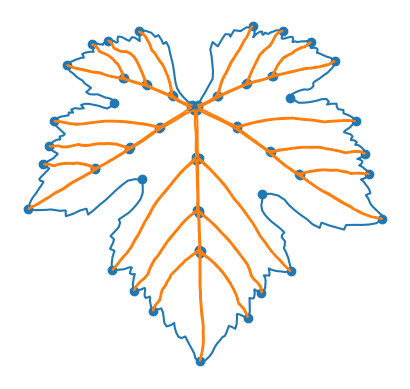

In [15]:
# check if code is working

plt.plot(scaled_blade[:,0], scaled_blade[:,1])
plt.plot(scaled_vein[:,0], scaled_vein[:,1])
plt.scatter(scaled_land[:,0], scaled_land[:,1])
plt.gca().set_aspect("equal")
plt.axis("off")

In [16]:
# CREATE PANEL

# inputs for plot
blade_color = "magenta"
blade_outline_color = "k"
vein_color = "white"
blade_outline_lw = 0.5
text_position = 0.85 # position within trans.figure in which right text block appears, 0-1
offset = 0.0 # offsets of text
fontsize = 14
linewidth = 1.5
filename = "example_leaf"

In [17]:
# calculate ampelographic parameters
leaf_type, sinus_type, A, B, C, r, Sp, S, Su_depth, In_depth, A_code, B_code, C_code, r_code, Sp_code, S_code, Su_code, In_code = galet_ampelography(scaled_land, scaled_vein, scaled_blade, blade_color, blade_outline_color, vein_color, blade_outline_lw, text_position, offset, fontsize, linewidth, filename)
    

# IMPORT MODULES

In [2]:
import numpy as np # for text file data
from scipy.interpolate import interp1d # for interpolating points
import matplotlib.pyplot as plt # for plotting
from pylab import *
%matplotlib inline
import pandas as pd # for working with dataframes
import seaborn as sns
from scipy.spatial import procrustes # for Procrustes analysis
from sklearn.decomposition import PCA # for principal component analysis
import math # for math
from math import atan2, degrees
from os import listdir # for reading in lists of files in folders 
from os.path import isfile, join

# FUNCTIONS

In [3]:
# define a function to reindex ad isolate start and end points of 
# a blade outline automatically extracted in ImageJ with landmark data
# inputs: arrays of landmark and blade trace data
# outputs: array of newly indexed blade data

def blade_reindex(landmarks, blade_trace):
    
    # retrieve blade start and end landmarks from landmarks file
    blade_start = landmarks[0,]
    blade_end = landmarks[64,]

    # create a list to store the distance of each blade point to the start landmark
    start_distances = []
    # create a list to store the distance of each blade point to the end landmark
    end_distances = []

    # for the number of points in the blade file
    # use np.shape, with "0" to count number of rows, or points in the data
    for i in range(np.shape(blade_trace)[0]):

        # calculate the euclidean distance of each blade point to
        # the start landmark and append to the start distance list
        start_distances.append(np.sqrt(
            (blade_start[0]-blade_trace[i,0])**2 + 
            (blade_start[1]-blade_trace[i,1])**2))

        # calculate the euclidean distance of each blade point to
        # the end landmark and append to the end distance list
        end_distances.append(np.sqrt(
            (blade_end[0]-blade_trace[i,0])**2 + 
            (blade_end[1]-blade_trace[i,1])**2))

    # find the indices of the minimum distance of the start and end to blade points
    start_index = start_distances.index(min(start_distances))
    end_index = end_distances.index(min(end_distances))
    
    # get number of coordinate values for the current blade
    num_coords = np.shape(blade_trace)[0] 

    # create an array to store new x and y vals using np.zeros
    reindexed_arr = np.zeros((num_coords,2)) 

    # for the number of points in the shape, i
    for i in range(num_coords):

        # get current index
        curr_ind = i 

        # get the new index to use
        new_ind = (i - start_index)%num_coords 

        # store the value at the new index position
        reindexed_arr[new_ind,:] = blade_trace[curr_ind,:] 

    # create new start and end index positions in reindexed data
    new_start_index = 0
    new_end_index = (end_index - start_index)%num_coords 
    
    new_blade_trace = reindexed_arr[new_start_index:(new_end_index+1), :]
    
    return new_blade_trace

# define a function to return equally spaced, interpolated points for a given polyline
# inputs: arrays of x and y values for a polyline, number of points to interpolate
# ouputs: interpolated points along the polyline, inclusive of start and end points

def interpolation(x, y, number): 

    distance = np.cumsum(np.sqrt( np.ediff1d(x, to_begin=0)**2 + np.ediff1d(y, to_begin=0)**2 ))
    distance = distance/distance[-1]

    fx, fy = interp1d( distance, x ), interp1d( distance, y )

    alpha = np.linspace(0, 1, number)
    x_regular, y_regular = fx(alpha), fy(alpha)
    
    return x_regular, y_regular

# define a function to replace points in trace file with nearest landmarks, 
# and return modified trace files and indices of landmarks in the trace
# inputs: arrays with x and y coordinates for the landmarks and trace, total resolution to interpolate over
# outputs: the indices of the landmarks in the returned modified trace files, now at specified resolution

def replace_with_landmarks(landmarks_file, trace_file, resolution):
    
    trace_xvals = trace_file[:,0] # specify trace xvals
    trace_yvals = trace_file[:,1] # specify trace yvals

    trace_xvals, trace_yvals = interpolation(trace_xvals,trace_yvals,resolution) # interpolate points to achieve high resolution

    new_xvals = trace_xvals # copy trace xvals to replace its trace vals with landmark vals
    new_yvals = trace_yvals # copy trace yvals to replace its trace vals with landmark vals

    land_indices = [] # list to store index values of landmarks in trace

    for i in range(landmarks_file.shape[0]): # for each landmark

        landx = landmarks_file[i,0] # select current landmark x val
        landy = landmarks_file[i,1] # select current landmark y val

        distances = [] # list to store distances of current landmark with each trace coord

        for j in range(len(trace_xvals)): # for each trace coord

            tracex = trace_xvals[j] # current trace x val
            tracey = trace_yvals[j] # current trace y val

            d = np.sqrt( (landx-tracex)**2 + (landy-tracey)**2 ) # find distance to each landmark for each trace

            distances.append(d) # append distance of landmark to each trace val

        min_val = np.min(distances) # find min distance value of a trace for the landmark
        min_ind = distances.index(min_val) # find min index value among trace coords to the landmark

        new_xvals[min_ind] = landx # change the trace x val to the landmark x val
        new_yvals[min_ind] = landy # change the trace y val to the landmark y val

        land_indices.append(min_ind) # append trace index that corresponds to landmark
        
    return land_indices, new_xvals, new_yvals

# define a function to return interpolated points for each interval between landmarks of a trace file
# inputs: landmark indices, xvals and yvals of polyline at desired resolution,
# number of interpolated landmarks per interval
# outputs: lists of x and y values with specified number of interpolated points per interval

def interpolated_intervals(land_indices, new_xvals, new_yvals, num_land):
    
    inter_points_x = [] # list to store interpolated x vals
    inter_points_y = [] # list to store interpolated y vals

    for i in range(len(land_indices)-1): # for each index, minus 1, because we are analyzing intervals

        beg_ind = land_indices[i] # specify the beginning point, based on index
        end_ind = land_indices[i+1] # specify the end point, based on index

        interval_xvals = new_xvals[beg_ind:end_ind] # using indices above, find the interval of x vals
        interval_yvals = new_yvals[beg_ind:end_ind] # using indices above, find the interval of y vals

        curr_inter_xvals, curr_inter_yvals = interpolation(interval_xvals, interval_yvals, num_land) # interpolate the interval

        curr_inter_xvals = list(curr_inter_xvals) # convert interval x vals into a list
        curr_inter_yvals = list(curr_inter_yvals) # convert interval y vals into a list

        # to prevent duplicated pseudo-landmark points, because we are working with intervals:

        if i==0: # if the first interval, delete the end point, because it will be covered in the next interval

            del curr_inter_xvals[-1]
            del curr_inter_yvals[-1]

        if i!=0: # if not the first interval, delete the start point, because it was covered in the previous interval

            del curr_inter_xvals[0]
            del curr_inter_yvals[0]

        for j in range(len(curr_inter_xvals)): # for the current interval points

            inter_points_x.append(curr_inter_xvals[j]) # append current interval x vals to list
            inter_points_y.append(curr_inter_yvals[j]) # append current interval y vals to list

    return inter_points_x, inter_points_y

# define a function taking landmark and vein and blade trace files interpolated outlines
# at specified number of landmarks per interval calculated from specified resolution
# inputs: landmark and vein and blade trace files, number of landmarks per interval, resolution
# outputs: interpolated x vals and y vals for the veins and blade, vein and blade landmarks

def interpolated_leaf(landmarks_file, vein_trace_file, blade_trace_file, num_land, resolution):

    # select vein and blade landmarks
    vein_landmarks = landmarks_file[0:65,:]
    blade_landmarks = landmarks_file[[0,2,5,8,10,65,13,16,19,21,66,24,27,30,32,34,37,40,67,43,45,48,51,68,54,56,59,62,64],:]

    # interpolate vein points
    vein_land_indices, vein_new_xvals, vein_new_yvals = replace_with_landmarks(vein_landmarks, vein_trace_file, resolution)
    vein_xvals, vein_yvals = interpolated_intervals(vein_land_indices, vein_new_xvals, vein_new_yvals, num_land)

    # interpolate blade points
    blade_land_indices, blade_new_xvals, blade_new_yvals = replace_with_landmarks(blade_landmarks, blade_trace_file, resolution)
    blade_xvals, blade_yvals = interpolated_intervals(blade_land_indices, blade_new_xvals, blade_new_yvals, num_land)

    return vein_xvals, vein_yvals, blade_xvals, blade_yvals

# define a function to find the angle between 3 points anti-clockwise in degrees, p2 being the vertex
# inputs: three angle points, as tuples
# output: angle in degrees

def angle_between(p1, p2, p3):
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    deg1 = (360 + math.degrees(atan2(x1 - x2, y1 - y2))) % 360
    deg2 = (360 + math.degrees(atan2(x3 - x2, y3 - y2))) % 360
    return deg2 - deg1 if deg1 <= deg2 else 360 - (deg1 - deg2)

# define a function to rotate 2D x and y coordinate points around the origin
# inputs: x and y vals (can take pandas dataframe columns) and the degrees (positive, anticlockwise) to rotate
# outputs: rotated and y vals

def rotate_points(xvals, yvals, degrees):
    
    angle_to_move = 270 - degrees
    rads = np.deg2rad(angle_to_move)
    
    new_xvals = xvals*np.cos(rads)-yvals*np.sin(rads)
    new_yvals = xvals*np.sin(rads)+yvals*np.cos(rads)
    
    return new_xvals, new_yvals

# define a function to rotate tip downwards, scale to centimeters, and translate petiolar junction to the origin
# inputs: interpolated x and y vein and blade values, landmarks, and px2 to cm2 scale
# outputs: rotated, scaled, and translated landmark, vein, and blade coordinates

def rotate_and_scale(vein_xvals, vein_yvals, blade_xvals, blade_yvals, landmarks, px2_cm2, filename):
    
    land_arr = landmarks # create landmarks coordinates array
    vein_arr = np.column_stack((vein_xvals, vein_yvals)) # create vein coordinates array
    blade_arr = np.column_stack((blade_xvals, blade_yvals)) # create blade coordinates array

    land_len = np.shape(landmarks)[0] # get lengths of landmark, vein, and blade arrays to retrieve coords later
    vein_len = np.shape(vein_arr)[0]
    blade_len = np.shape(blade_arr)[0]
    overall_len = land_len + vein_len + blade_len

    overall_arr = np.row_stack((landmarks, vein_arr, blade_arr)) # stack land, vein, blade arrays into single array

    px_cm = np.sqrt(px2_cm2) # take square root of scaling factor to scale pixels to cm
    scaled_arr = overall_arr/px_cm # convert pixels into 
    tip_to_base_cm = np.sqrt((scaled_arr[32,0]-scaled_arr[0,0])**2  # get distance in pixels from tip to base of leaf
                             + (scaled_arr[32,1]-scaled_arr[0,1])**2) # use to scale PC values back to cm later
    
    # perform a principal component analysis on data to center
    
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(overall_arr)
    df = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])
    
    # find the angle of the leaf tip relative to the origin
    
    p1 = (df["pc1"].loc[32,], df["pc2"].loc[32,]) # get leaf tip PC1/PC2 coordinate value
    p2 = (0,0) # find angle relative to vertex at origin
    p3 = (10,0) # an arbitrary positive point along the x axis to find angle in anticlockwise direction

    angle = angle_between(p1, p2, p3) # find the angle in degrees of tip point relative to origin, anticlockwise

    rotated_xvals, rotated_yvals = rotate_points(df["pc1"], df["pc2"], angle)

    rotated_arr = np.column_stack((rotated_xvals, rotated_yvals)) # stack x and y vals back into one array

    tip_to_base_pca = np.sqrt((rotated_arr[32,0]-rotated_arr[0,0])**2 # find the distance in PC vals between tip and base
                              + (rotated_arr[32,1]-rotated_arr[0,1])**2)

    scale = tip_to_base_cm/tip_to_base_pca # find the factor to scale back to cm

    scaled_arr = rotated_arr*scale # scale rotated PC vals back to cm
    
    pet_junc = np.mean(scaled_arr[[0,64],:],axis=0)
    
    trans_x = scaled_arr[:,0] - pet_junc[0]
    trans_y = scaled_arr[:,1] - pet_junc[1]
    
    scaled_arr = np.column_stack((trans_x, trans_y))
    
    if scaled_arr[10,0] < 0: # insure left side of the leaf is left so labels are on right side of plot
        scaled_arr[:,0] = -scaled_arr[:,0]
        
    scaled_land = scaled_arr[0:land_len,] # isolate just landmarks
    scaled_vein = scaled_arr[land_len:(land_len+vein_len),] # isolate just vein coords
    scaled_blade = scaled_arr[(land_len+vein_len):(land_len+vein_len+blade_len),] # isolate just blade coords
    
    np.savetxt("./highres_landmarks/" + filename + "_scaled_landmarks.txt", scaled_land) # save landmark data to landmarks folder
    np.savetxt("./highres_landmarks/" + filename + "_scaled_veins.txt", scaled_vein) # save vein data to landmarks folder
    np.savetxt("./highres_landmarks/" + filename + "_scaled_blade.txt", scaled_blade) # save vein data to landmarks folder
    
    return scaled_land, scaled_vein, scaled_blade # return scaled and rotated landmarks, vein, and blade

# define a function to calculate Galet ampelographic traits and plot leaf, as defined in A Practical Ampelography
# inputs: rotated, scaled, translated landmark, vein, and blade coordinates, plot parameters
# outputs: ampelographic parameters, saved image file to folder /data

def galet_ampelography(scaled_land, scaled_vein, scaled_blade, blade_color, blade_outline_color, vein_color, blade_outline_lw, text_position, offset, fontsize, linewidth, filename):    
    
    ####################################################
    # How to Measure and Encode the Lengths of the Veins
    # page 45 Cornell edition A Practical Ampelography
    ####################################################

    pet_junc = np.mean(scaled_land[[0,64],:],axis=0)
    L1 = scaled_land[32,:]
    L2 = scaled_land[21,:] # calculate points for left side
    L3 = scaled_land[10,:]
    L4 = scaled_land[2,:]
    pet_vein = np.mean(scaled_land[[1,3],:],axis=0)

    L2p = scaled_land[43,:] # calculate points for right side
    L3p = scaled_land[54,:]
    L4p = scaled_land[62,:]
    pet_veinp = np.mean(scaled_land[[61,63],:],axis=0)

    L1_len = np.sqrt((L1[0]-pet_junc[0])**2 + (L1[1]-pet_junc[1])**2) # calculate lengths for left side
    L2_len = np.sqrt((L2[0]-pet_junc[0])**2 + (L2[1]-pet_junc[1])**2)
    L3_len = np.sqrt((L3[0]-pet_junc[0])**2 + (L3[1]-pet_junc[1])**2)
    L4_len = np.sqrt((L4[0]-pet_vein[0])**2 + (L4[1]-pet_vein[1])**2)

    L2p_len = np.sqrt((L2[0]-pet_junc[0])**2 + (L2[1]-pet_junc[1])**2) # calculate lengths for right side
    L3p_len = np.sqrt((L3[0]-pet_junc[0])**2 + (L3[1]-pet_junc[1])**2)
    L4p_len = np.sqrt((L4[0]-pet_vein[0])**2 + (L4[1]-pet_vein[1])**2)

    A = L2_len/L1_len # calculate ratios for left side
    B = L3_len/L1_len
    C = L4_len/L1_len

    Ap = L2p_len/L1_len # calculate ratios for right side
    Bp = L3p_len/L1_len
    Cp = L4p_len/L1_len

    A = (A+Ap)/2 # calcualte averages of sides
    B = (B+Bp)/2
    C = (C+Cp)/2

    # Galet code for A, L2/L1
    if (A > 0.9) and (A <= 1.0):
        A_code = 0
    elif (A > 0.8) and (A <= 0.9):
        A_code = 1
    elif (A > 0.7) and (A <= 0.8):
        A_code = 2
    elif (A > 0.6) and (A <= 0.7):
        A_code = 3
    elif (A > 0.5) and (A <= 0.6):
        A_code = 4
    elif (A > 0.4) and (A <= 0.5):
        A_code = 5
    elif (A > 0.3) and (A <= 0.4):
        A_code = 6
    elif (A > 0.2) and (A <= 0.3):
        A_code = 7
    elif (A > 0.1) and (A <= 0.2):
        A_code = 8
    else:
        A_code = 9

    # Galet code for B, L3/L1
    if (B > 0.9) and (B <= 1.0):
        B_code = 0
    elif (B > 0.8) and (B <= 0.9):
        B_code = 1
    elif (B > 0.7) and (B <= 0.8):
        B_code = 2
    elif (B > 0.6) and (B <= 0.7):
        B_code = 3
    elif (B > 0.5) and (B <= 0.6):
        B_code = 4
    elif (B > 0.4) and (B <= 0.5):
        B_code = 5
    elif (B > 0.3) and (B <= 0.4):
        B_code = 6
    elif (B > 0.2) and (B <= 0.3):
        B_code = 7
    elif (B > 0.1) and (B <= 0.2):
        B_code = 8
    else:
        B_code = 9

    # Galet code for C, L4/L1
    if (C > 0.9) and (C <= 1.0):
        C_code = 0
    elif (C > 0.8) and (C <= 0.9):
        C_code = 1
    elif (C > 0.7) and (C <= 0.8):
        C_code = 2
    elif (C > 0.6) and (C <= 0.7):
        C_code = 3
    elif (C > 0.5) and (C <= 0.6):
        C_code = 4
    elif (C > 0.4) and (C <= 0.5):
        C_code = 5
    elif (C > 0.3) and (C <= 0.4):
        C_code = 6
    elif (C > 0.2) and (C <= 0.3):
        C_code = 7
    elif (C > 0.1) and (C <= 0.2):
        C_code = 8
    else:
        C_code = 9

    #######################################
    # Code for the Ratio of Length to Width
    # page 46 Cornell edition A Practical Ampelography
    #######################################

    length = np.max(scaled_blade[:,1]) - np.min(scaled_blade[:,1]) # calculate overall length
    width = np.max(scaled_blade[:,0]) - np.min(scaled_blade[:,0]) # calculate overall width
    r = length/width # calculate r

    # Galet code for r, length/width
    if r <= 0.8:
        r_code = 0
    elif (r > 0.8) and (r <= 0.9):
        r_code = 1
    elif (r > 0.9) and (r <= 1.0):
        r_code = 2
    elif (r > 0.9) and (r <= 1.0):
        rcode = 2
    elif (r > 1.0) and (r <= 1.10):
        r_code = 3
    elif (r > 1.10) and (r <= 1.20):
        r_code = 4
    elif (r > 1.20) and (r <= 1.30):
        r_code = 5
    elif (r > 1.30) and (r <= 1.40):
        r_code = 6
    else:
        r_code= 6

    ######################################
    # How to Measure and Encode the Angles
    # page 46 Cornell edition A Practical Ampelography
    ######################################

    H = angle_between(L4, pet_vein, L3) # calculate angles for left side
    G = angle_between(L3, pet_junc, L2)
    F = angle_between(L2, pet_junc, L1)

    Hp = angle_between(L3p, pet_veinp, L4p) # calculate angles for right side
    Gp = angle_between(L2p, pet_junc, L3p)
    Fp = angle_between(L1, pet_junc, L2p)

    H = (H + Hp)/2 # calculate mean angles
    G = (G + Gp)/2
    F = (F + Fp)/2

    Sp = G + F # calculate overall angles S and S'
    S = Sp + H

    # Galet code for S prime (Sp), F + G, the angle between L1 and L3

    if Sp <= 70:
        Sp_code = 0
    elif (Sp > 70) and (Sp <= 80):
        Sp_code = 1
    elif (Sp > 80) and (Sp <= 90):
        Sp_code = 2
    elif (Sp > 90) and (Sp <= 100):
        Sp_code = 3
    elif (Sp > 100) and (Sp <= 110):
        Sp_code = 4
    elif (Sp > 110) and (Sp <= 120):
        Sp_code = 5
    elif (Sp > 120) and (Sp <= 130):
        Sp_code = 6
    elif (Sp > 130) and (Sp <= 140):
        Sp_code = 7
    elif (Sp > 140) and (Sp <= 150):
        Sp_code = 8
    else:
        Sp_code = 9

    # Galet code for S (S), Sp + H, the angle between L1 and L4

    if S <= 100:
        S_code = 0
    elif (S > 100) and (S <= 110):
        S_code = 1
    elif (S > 110) and (S <= 120):
        S_code = 2
    elif (S > 120) and (S <= 130):
        S_code = 3
    elif (S > 130) and (S <= 140):
        S_code = 4
    elif (S > 140) and (S <= 150):
        S_code = 5
    elif (S > 150) and (S <= 160):
        S_code = 6
    elif (S > 160) and (S <= 170):
        S_code = 7
    elif (S > 170) and (S <= 180):
        S_code = 8
    else:
        S_code = 9

    ######################################
    # How to Measure and Encode the Depth of the Lateral Sinuses
    # page 47 Cornell edition A Practical Ampelography
    ######################################

    Su = scaled_land[66,:] # calculate points for left side
    In = scaled_land[65,:]

    Sup = scaled_land[67,:] # calculate points for right side
    Inp = scaled_land[68,:]

    Su_len = np.sqrt((Su[0]-pet_junc[0])**2 + (Su[1]-pet_junc[1])**2) # calculate lengths for left side
    In_len = np.sqrt((In[0]-pet_junc[0])**2 + (In[1]-pet_junc[1])**2) 

    Sup_len = np.sqrt((Sup[0]-pet_junc[0])**2 + (Sup[1]-pet_junc[1])**2) # calculate lengths for right side
    Inp_len = np.sqrt((Inp[0]-pet_junc[0])**2 + (Inp[1]-pet_junc[1])**2) 

    Su_depth = Su_len/L2_len # calculate sinus depths for each side and their averages
    Sup_depth = Sup_len/L2p_len
    Su_depth = (Su_depth+Sup_depth)/2

    In_depth = In_len/L3_len
    Inp_depth = Inp_len/L3p_len
    In_depth = (In_depth+Inp_depth)/2

    # Galet code for Su_depth, Su/L2
    if (Su_depth > 0.9) and (Su_depth <= 1.0):
        Su_code = 0
    elif (Su_depth > 0.8) and (Su_depth <= 0.9):
        Su_code = 1
    elif (Su_depth > 0.7) and (Su_depth <= 0.8):
        Su_code = 2
    elif (Su_depth > 0.6) and (Su_depth <= 0.7):
        Su_code = 3
    elif (Su_depth > 0.5) and (Su_depth <= 0.6):
        Su_code = 4
    elif (Su_depth > 0.4) and (Su_depth <= 0.5):
        Su_code = 5
    elif (Su_depth > 0.3) and (Su_depth <= 0.4):
        Su_code = 6
    elif (Su_depth > 0.2) and (Su_depth <= 0.3):
        Su_code = 7
    elif (Su_depth > 0.1) and (Su_depth <= 0.2):
        Su_code = 8
    else:
        Su_code = 9

    # Galet code for In_depth, In/L3
    if (In_depth > 0.9) and (In_depth <= 1.0):
        In_code = 0
    elif (In_depth > 0.8) and (In_depth <= 0.9):
        In_code = 1
    elif (In_depth > 0.7) and (In_depth <= 0.8):
        In_code = 2
    elif (In_depth > 0.6) and (In_depth <= 0.7):
        In_code = 3
    elif (In_depth > 0.5) and (In_depth <= 0.6):
        In_code = 4
    elif (In_depth > 0.4) and (In_depth <= 0.5):
        In_code = 5
    elif (In_depth > 0.3) and (In_depth <= 0.4):
        In_code = 6
    elif (In_depth > 0.2) and (In_depth <= 0.3):
        In_code = 7
    elif (In_depth > 0.1) and (In_depth <= 0.2):
        In_code = 8
    else:
        In_code = 9

    # Base the sinus depth classification based on Su_code
    if Su_code <= 2:
        sinus_type = "Entire, nearly entire, or faintly lobed"
    elif (Su_code > 2) and (Su_code <= 4):
        sinus_type = "Lobing is average"
    elif (Su_code > 4) and (Su_code <= 6):
        sinus_type = "Deeply to very deeply lobed"
    else:
        sinus_type = "Palmatisected or cut to the petiolar junction"

    ######################################
    # Find the Galet leaf type
    # based on pages 30-31 Cornell edition A Practical Ampelography
    ###################################### 

    galet_form_arr = np.array([A_code,B_code,C_code,r_code,Sp_code,S_code]) # Galet formula as an array

    ren1 = np.array([0,2,5,1,0,0]) # convert Galet formulas of leaf types on pp 30-31 into arrays
    ren2 = np.array([0,3,6,1,0,0])
    cun1 = np.array([1,4,6,3,0,0])
    cor1 = np.array([3,5,7,4,0,0])

    orb_ren1 = np.array([0,2,5,2,3,5])
    orb_ren2 = np.array([0,3,6,3,3,6])
    cun2 = np.array([1,4,6,3,3,5])
    cor2 = np.array([3,5,7,3,3,5])

    orb1 = np.array([0,2,5,2,5,7])
    orb2 = np.array([0,3,6,2,5,7])
    cun_tru1 = np.array([1,4,6,2,5,7])
    cor3 = np.array([3,5,7,4,5,7])

    orb3 = np.array([0,2,5,2,6,9])
    orb4 = np.array([0,3,6,2,6,9])
    tru1 = np.array([1,4,6,2,6,9])
    cor4 = np.array([3,5,7,5,6,9])

    types_list = [ren1, ren2, cun1, cor1, # place leaf type arrays into a list
                  orb_ren1, orb_ren2, cun2, cor2, 
                  orb1, orb2, cun_tru1, cor3, 
                  orb3, orb4, tru1, cor4]

    names_list = ["Reniform", "Reniform", "Cuneiform", "Cordiform", # provide names for each leaf type
                 "Orbicular-reniform", "Orbicular-reniform", "Cuneiform", "Cordiform",
                  "Orbicular", "Orbicular", "Cuneo-truncate", "Cordiform",
                  "Orbicular", "Orbicular", "Truncate", "Cordiform"
                 ]

    # find closest leaf type to current leaf Galet formula by least squares

    sum_sqs_list = [] # list to store sum of the squares

    for i in range(len(types_list)):

        curr_arr = types_list[i]

        sum_sqs = np.sum( (galet_form_arr - curr_arr)**2 ) # calculate squared difference from each leaf type
        sum_sqs_list.append(sum_sqs)

    min_ind = sum_sqs_list.index(min(sum_sqs_list)) # find index of minimum sum of squares

    leaf_type = names_list[min_ind] # identify leaf type based on sum of squares
    
    ######################################
    # Create a figure
    # inspired from page 27 Cornell edition A Practical Ampelography
    ###################################### 
    
    
    plt.figure(figsize=(11,8.5)) # set to letter size

    plt.fill(scaled_blade[:,0], scaled_blade[:,1], c=blade_color) # plot blade and veins as fill
    plt.fill(scaled_vein[:,0], scaled_vein[:,1], c=vein_color)
    #plt.plot(scaled_blade[:,0], scaled_blade[:,1], c=blade_outline_color, lw=blade_outline_lw) # plot blade outline

    # text of points
    plt.text(pet_junc[0], pet_junc[1]+offset, "O", fontsize=fontsize, horizontalalignment="center", verticalalignment="center", fontstyle="italic")
    plt.text(L1[0], L1[1]-offset, "L1", fontsize=fontsize, horizontalalignment="center", verticalalignment="center")
    plt.text(L2[0]+offset, L2[1], "L2", fontsize=fontsize, horizontalalignment="center", verticalalignment="center")
    plt.text(L3[0]+offset, L3[1], "L3", fontsize=fontsize, horizontalalignment="center", verticalalignment="center")
    plt.text(L4[0], L4[1]+offset, "L4", fontsize=fontsize, horizontalalignment="center", verticalalignment="center")
    plt.text(Su[0], Su[1]-offset, "Su", fontsize=fontsize, horizontalalignment="center", verticalalignment="center", fontstyle="italic")
    plt.text(In[0], In[1]-offset, "In", fontsize=fontsize, horizontalalignment="center", verticalalignment="center", fontstyle="italic")

    # text of angles
    plt.text(scaled_land[27,0], scaled_land[27,1], r"$\measuredangle$F", fontsize=fontsize, horizontalalignment="center", verticalalignment="center")
    plt.text(scaled_land[16,0], scaled_land[16,1], r"$\measuredangle$G", fontsize=fontsize, horizontalalignment="center", verticalalignment="center")
    plt.text(scaled_land[5,0], scaled_land[5,1], r"$\measuredangle$H", fontsize=fontsize, horizontalalignment="center", verticalalignment="center")

    # text of data

    plt.text(text_position, 0.85, species, transform=plt.gcf().transFigure, fontsize=fontsize*1.5)
    plt.text(text_position, 0.78, leaf_type + "\n" + sinus_type, transform=plt.gcf().transFigure, fontsize=fontsize)

    plt.text(text_position, 0.32, "Galet formula\n" + 
             r"A = $\dfrac{L2}{L1}$ = " + str(round(A,2)) + r"$\equiv$" + str(A_code) + "\n" +
             r"B = $\dfrac{L3}{L1}$ = " + str(round(B,2)) + r"$\equiv$" + str(B_code) + "\n" +
             r"C = $\dfrac{L4}{L1}$ = " + str(round(C,2)) + r"$\equiv$" + str(C_code) + "\n" +
             r"r = $\dfrac{length}{width}$ = " + str(round(r,2)) + r"$\equiv$" + str(r_code) + "\n" +
             r"$\measuredangle$S' = $\measuredangle$F+$\measuredangle$G = " + str(round(Sp,1)) + r"$^\circ$" + r"$\equiv$" + str(Sp_code) + "\n" +
             r"$\measuredangle$S = $\measuredangle$S'+$\measuredangle$H = " + str(round(S,1)) + r"$^\circ$" + r"$\equiv$" + str(S_code) + "\n" +
             r"$\dfrac{OSu}{L2}$ = " + str(round(Su_depth,2)) + r"$\equiv$" + str(Su_code) + "\n" +
             r"$\dfrac{OIn}{L3}$ = " + str(round(In_depth,2)) + r"$\equiv$" + str(In_code) + "\n" ,

             transform=plt.gcf().transFigure, fontsize=fontsize
            )

    plt.text(text_position, 0.12, "Dataset: " + dataset + "\n" +
             "Vine: " + vine + "\n" +
             "Leaf: " + leaf + "\n" +
             "Image: " + image + "\n" +
             "Source: " + source + "\n" +
             r"$\frac{pixels^2}{cm^2}$: " + str(px2_cm2),

             transform=plt.gcf().transFigure, fontsize=fontsize)

    # plot lengths
    plt.plot([pet_junc[0],Su[0]], [pet_junc[1],Su[1]], c="gray", linestyle="dotted", lw=linewidth)
    plt.plot([pet_junc[0],In[0]], [pet_junc[1],In[1]], c="gray", linestyle="dotted", lw=linewidth)
    plt.plot([pet_junc[0],L1[0]], [pet_junc[1],L1[1]], c="gray", linestyle="solid", lw=linewidth)
    plt.plot([pet_junc[0],L2[0]], [pet_junc[1],L2[1]], c="gray", linestyle="solid", lw=linewidth)
    plt.plot([pet_junc[0],L3[0]], [pet_junc[1],L3[1]], c="gray", linestyle="solid", lw=linewidth)
    plt.plot([pet_vein[0],L3[0]], [pet_vein[1],L3[1]], c="gray", linestyle="solid", lw=linewidth)
    plt.plot([pet_vein[0],L4[0]], [pet_vein[1],L4[1]], c="gray", linestyle="solid", lw=linewidth)

    # other parameters
    plt.xlabel("centimeters")
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().set_aspect("equal")
    ax = plt.gca() #get current axes
    ax.get_yaxis().set_visible(False) #hide y-axis
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(False)

    plt.savefig("./panels/" + filename + "_plot.jpg", bbox_inches='tight') # save plot to images folder
    plt.close()
    
    return leaf_type, sinus_type, A, B, C, r, Sp, S, Su_depth, In_depth, A_code, B_code, C_code, r_code, Sp_code, S_code, Su_code, In_code

# define a function to calculate the area of a polygon using the shoelace algorithm
# inputs: separate numpy arrays of x and y coordinate values
# outputs: the area of the polygon

def PolyArea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))



# READ IN AND PROCESS DATA

In [3]:
# a list with leaf IDs to read in and process data
leaf_list = [
             
            # SPECIES TYPES
            "000_VITISACERIFOLIA", #1
            "000_VITISAESTIVALIS", #2
            "000_VITISAMURENSIS", #3
            "000_VITISCINEREA", #4
            "000_VITISCOIGNETIAE", #5
            "000_VITISLABRUSCA", #6
            "000_VITISPALMATA", #7
            "000_VITISPIASEZKII", #8
            "000_VITISRIPARIA", #9
            "000_VITISRUPESTRIS", #10
            "000_VITISTHUNBERGII", #11
            "000_VITISVULPINA", #12
    
            # VARIETY TYPES
            "000_ALICANTEBOUSCHET", #13
            "000_CABERNETSAUVIGNON", #14
            "000_CHARDONNAY", #15
            "000_CHASSELASCIOUTAT", #16
            "000_CHASSELASDORE", #17
            "000_FLAMETOKAY", #18
            "000_GEWURTZTRAMINER", #19
            "000_PINOTNOIR", #20
            "000_SYLVANER", #21
            "000_SYRAH", #22
            "000_WHITERIESLING", #23
            "000_ZINFANDEL", #24
    
            # ERROR REDUCTION
            "001_leaf4_588147a", #25, Vitis rupestris
            "002_leaf1_wGVIT1627a", #26, Ampelopsis aconitifolia
            "003_leaf5_588147a", #27, Vitis rupestris
            "004_leafb_K1164A", #28, Chasselas cioutat
            "005_leafc_K1163A", #29, Chasselas cioutat
            "006_leaf2_483180a", #30, Vitis vulpina
            "007_leaf8_w588055a", #31, Vitis thunbergii
            "008_leaf2_wGVIT1626a", #32, Ampelopsis glandulosa var. brevipedunculata
            "009_leaf10_wGVIT1626b", #33, Ampelopsis glandulosa var. brevipedunculata
            "010_leaf2_483186a", #34, Vitis vulpina
            "011_leaf11_597257a", #35, Vitis piasezkii
            "012_leafd_K1163A", #36, Chasselas cioutat
            "013_leaf6_wGVIT1627a", #37, Ampelopsis aconitifolia
            "014_leaf3_588538a", #38, Ampelopsis glandulosa var. brevipedunculata
            "015_leaf1_279897a", #39, Vitis riparia
            "016_leaf9_588174a", #40, Vitis rupestris
            "017_leaf9_wGVIT1627a", #41, Ampelopsis aconitifolia
    
            # VITIS CINEREA TIME SERIES
            "018_leaf1_588154a", #42, Vitis cinerea, leaf 1
            "019_leaf2_588154a", #43, Vitis cinerea, leaf 2
            "020_leaf3_588154a", #44, Vitis cinerea, leaf 3
            "021_leaf4_588154a", #45, Vitis cinerea, leaf 4
    
            # VITIS RUPESTRIS TIME SERIES
            "022_leaf1_588174a", #46, Vitis rupestris, leaf 1
            "023_leaf2_588174a", #47, Vitis rupestris, leaf 2
            "024_leaf3_588174a", #48, Vitis rupestris, leaf 3
            "025_leaf4_588174a", #49, Vitis rupestris, leaf 4
    
            # VITIS RIPARIA TIME SERIES
            "026_leaf1_313922a", #50, Vitis riparia, leaf 1
            "027_leaf2_313922a", #51, Vitis riparia, leaf 2
            "028_leaf3_313922a", #52, Vitis riparia, leaf 3
            "029_leaf4_313922a", #53, Vitis riparia, leaf 4
    
            # VITIS LABRUSCA TIME SERIES
            "030_leaf1_483146a", #54, Vitis labrusca, leaf 1
            "031_leaf2_483146a", #55, Vitis labrusca, leaf 2
            "032_leaf3_483146a", #56, Vitis labrusca, leaf 3
            "033_leaf4_483146a", #57, Vitis labrusca, leaf 4
    
            # VITIS ACERIFOLIA TIME SERIES
            "034_leaf1_588393a", #58, Vitis acerifolia, leaf 1
            "035_leaf2_588393a", #59, Vitis acerifolia, leaf 2
            "036_leaf3_588393a", #60, Vitis acerifolia, leaf 3
            "037_leaf4_588393a", #61, Vitis acerifolia, leaf 4
    
            # VITIS AMURENSIS TIME SERIES
            "038_leaf1_588631a", #62, Vitis amurensis, leaf 1
            "039_leaf2_588631a", #63, Vitis amurensis, leaf 2
            "040_leaf3_588631a", #64, Vitis amurensis, leaf 3
            "041_leaf4_588631a", #65, Vitis amurensis, leaf 4
    
            # VITIS VULPINA TIME SERIES
            "042_leaf1_483187a", #66, Vitis vulpina, leaf 1
            "043_leaf2_483187a", #67, Vitis vulpina, leaf 2
            "044_leaf3_483187a", #68, Vitis vulpina, leaf 3
            "045_leaf4_483187a", #69, Vitis vulpina, leaf 3
    
            # VITIS AESTIVALIS TIME SERIES
            "046_leaf1_483138a", #70, Vitis aestivalis, leaf 1
            "047_leaf2_483138a", #71, Vitis aestivalis, leaf 2
            "048_leaf3_483138a", #72, Vitis aestivalis, leaf 3
            "049_leaf4_483138a", #73, Vitis aestivalis, leaf 4
    
            # VITIS COIGNETIAE TIME SERIES
            "050_leaf1_w588451a", #74, Vitis coignetiae, leaf 1
            "051_leaf2_w588451a", #75, Vitis coignetiae, leaf 2
            "052_leaf3_w588451a", #76, Vitis coignetiae, leaf 3
            "053_leaf4_w588451a", #77, Vitis coignetiae, leaf 4
    
            # VITIS PALMATA TIME SERIES
            "054_leaf1_588233a", #78, Vitis palmata, leaf 1
            "055_leaf2_588233a", #79, Vitis palmata, leaf 2
            "056_leaf3_588233a", #80, Vitis palmata, leaf 3
            "057_leaf4_588233a" #81, Vitis palmata, leaf 4
]

# create a list of leaf categories
label_list = [
              "wild","wild","wild","wild","wild","wild",
              "wild","wild","wild","wild","wild","wild",
              "vinifera","vinifera","vinifera","vinifera","vinifera","vinifera",
              "vinifera","vinifera","vinifera","vinifera","vinifera","vinifera",
              "error","error","error","error","error","error",
              "error","error","error","error","error","error",
              "error","error","error","error","error",
              "leaf1","leaf2","leaf3","leaf4",
              "leaf1","leaf2","leaf3","leaf4",
              "leaf1","leaf2","leaf3","leaf4",
              "leaf1","leaf2","leaf3","leaf4",
              "leaf1","leaf2","leaf3","leaf4",
              "leaf1","leaf2","leaf3","leaf4",
              "leaf1","leaf2","leaf3","leaf4",
              "leaf1","leaf2","leaf3","leaf4",
              "leaf1","leaf2","leaf3","leaf4",
              "leaf1","leaf2","leaf3","leaf4"
]

# a list of colors and cycle through leaves
color_list = ["#a6d854", "#fc8d62", "#ffd92f", "#e78ac3", "#8da0cb", "#66c2a5" ]

# lists to store data for later
species_list = []
node_list = []

for i in range(len(leaf_list)): # for each leaf in leaf_list

    curr_leaf = leaf_list[i]
    
    print(i, curr_leaf)

    # read in data from ./data folder

    landmarks = np.loadtxt("./highres_data/" + curr_leaf + "_landmarks.txt") # landmark points
    vein_trace = np.loadtxt("./highres_data/" + curr_leaf + "_veins.txt") # vein trace outline
    blade_trace = np.loadtxt("./highres_data/" + curr_leaf + "_blade.txt") # blade trace outline
    info_df = pd.read_csv("./highres_data/" + curr_leaf + "_info.csv") # read in metadata

    # unpack metadata
    
    species = info_df.iloc[0,1] 
    species_list.append(species)
    
    dataset = info_df.iloc[1,1]
    vine = info_df.iloc[2,1]
    
    leaf = info_df.iloc[3,1]
    node_list.append(leaf)
    
    image = info_df.iloc[4,1]
    source = info_df.iloc[5,1]
    px2_cm2 = float(info_df.iloc[6,1])
    
    # inputs for interpolation
    landmarks_file = landmarks
    vein_trace_file = vein_trace
    blade_trace_file = blade_trace
    num_land = 20
    resolution = 10000
    filename = curr_leaf
    
    # inputs for plot
    color_index = i%6
    blade_color = color_list[color_index]
    blade_outline_color = "k"
    vein_color = "white"
    blade_outline_lw = 0.5
    text_position = 0.85 # position within trans.figure in which right text block appears, 0-1
    offset = 0.0 # offsets of text
    fontsize = 14
    linewidth = 1.5
    filename = curr_leaf
    
    ###############
    # PROCESS DATA
    ##############
    
    # create interpolated coordinates
    vein_xvals, vein_yvals, blade_xvals, blade_yvals = interpolated_leaf(landmarks_file, vein_trace_file, blade_trace_file, num_land, resolution)

    # scale, rotate, and translate coordinates
    scaled_land, scaled_vein, scaled_blade = rotate_and_scale(vein_xvals, vein_yvals, blade_xvals, blade_yvals, landmarks, px2_cm2, filename)

    # calculate ampelographic parameters
    leaf_type, sinus_type, A, B, C, r, Sp, S, Su_depth, In_depth, A_code, B_code, C_code, r_code, Sp_code, S_code, Su_code, In_code = galet_ampelography(scaled_land, scaled_vein, scaled_blade, blade_color, blade_outline_color, vein_color, blade_outline_lw, text_position, offset, fontsize, linewidth, filename)
    


0 000_VITISACERIFOLIA
1 000_VITISAESTIVALIS
2 000_VITISAMURENSIS
3 000_VITISCINEREA
4 000_VITISCOIGNETIAE
5 000_VITISLABRUSCA
6 000_VITISPALMATA
7 000_VITISPIASEZKII
8 000_VITISRIPARIA
9 000_VITISRUPESTRIS
10 000_VITISTHUNBERGII
11 000_VITISVULPINA
12 000_ALICANTEBOUSCHET
13 000_CABERNETSAUVIGNON
14 000_CHARDONNAY
15 000_CHASSELASCIOUTAT
16 000_CHASSELASDORE
17 000_FLAMETOKAY
18 000_GEWURTZTRAMINER
19 000_PINOTNOIR
20 000_SYLVANER
21 000_SYRAH
22 000_WHITERIESLING
23 000_ZINFANDEL
24 001_leaf4_588147a
25 002_leaf1_wGVIT1627a
26 003_leaf5_588147a
27 004_leafb_K1164A
28 005_leafc_K1163A
29 006_leaf2_483180a
30 007_leaf8_w588055a
31 008_leaf2_wGVIT1626a
32 009_leaf10_wGVIT1626b
33 010_leaf2_483186a
34 011_leaf11_597257a
35 012_leafd_K1163A
36 013_leaf6_wGVIT1627a
37 014_leaf3_588538a
38 015_leaf1_279897a
39 016_leaf9_588174a
40 017_leaf9_wGVIT1627a
41 018_leaf1_588154a
42 019_leaf2_588154a
43 020_leaf3_588154a
44 021_leaf4_588154a
45 022_leaf1_588174a
46 023_leaf2_588174a
47 024_leaf3_588

# LANDMARK NUMBER

In [4]:
# 19 landmarks per segment
# currently 64 vein segments
# currently 28 blade segments
# currently 69 landmarks

num_samples = len(leaf_list) # record number of samples

landmarks_len = 69 # record the number of true landmarks
vein_len = 1216 # record the number of vein landmarks
blade_len = 532 # record the number of blade landmarks
total_length = landmarks_len+vein_len+blade_len # the total number of vein + blade landmarks combined

# print out landmark numbers for reference
print("there are", num_samples, "samples\nthere are",
    landmarks_len, "true landmarks\nthere are",
      vein_len, "vein landmarks\nthere are", 
      blade_len, "blade landmarks\nthere are", 
      total_length, "landmarks total")


there are 81 samples
there are 69 true landmarks
there are 1216 vein landmarks
there are 532 blade landmarks
there are 1817 landmarks total


# CREATE SHAPE DATA

In [5]:
shape_list = [] # a list of arrays for each leaf

for i in range(len(leaf_list)):
    
    curr_leaf = leaf_list[i] # select current leaf
    # print(i, curr_leaf) # print current leaf
    
    curr_landmarks = np.loadtxt("./highres_landmarks/" + curr_leaf + "_scaled_landmarks.txt") # load in true landmarks
    curr_veins = np.loadtxt("./highres_landmarks/" + curr_leaf + "_scaled_veins.txt") # load in vein landmarks
    curr_blade = np.loadtxt("./highres_landmarks/" + curr_leaf + "_scaled_blade.txt") # load in blade landmarks
    
    curr_land_veins_blade = np.row_stack((curr_landmarks, curr_veins, curr_blade)) # stack vein landmarks on top of blade
    
    shape_list.append(curr_land_veins_blade) # add the stacked vein-blade landmark array to shape_list
    

# VEIN-TO-BLADE RATIO

In [6]:
vtb_min = -4 # set value to normalize vein to blade ratio color
cmap = cm.get_cmap('plasma', 100) # set the color map

leaf_areas = [] # store leaf areas
vtb_ratios = [] # store vein-to-blade ratios
hex_colors = [] # store hex colors

for i in range(len(shape_list)): # for each leaf
    
    curr_leaf = shape_list[i] # get current leaf
    
    curr_veins = curr_leaf[69:1285] # get vein landmarks
    curr_blade = curr_leaf[1285:] # get blade landmarks
    
    leaf_area = PolyArea(curr_blade[:,0], curr_blade[:,1]) # get leaf area
    vein_area = PolyArea(curr_veins[:,0], curr_veins[:,1]) # get vein area
    blade_area = leaf_area - vein_area # get blade area
    
    vtb_ratio = np.log(vein_area/blade_area) # calculate vein-to-blade ratio
    vtb_normal = vtb_ratio/vtb_min # normalize vein-to-blade ratio
    hexcol = matplotlib.colors.rgb2hex(cmap(vtb_normal)) # get hexcolor
    
    leaf_areas.append(leaf_area) # store data
    vtb_ratios.append(vtb_ratio)
    hex_colors.append(hexcol)

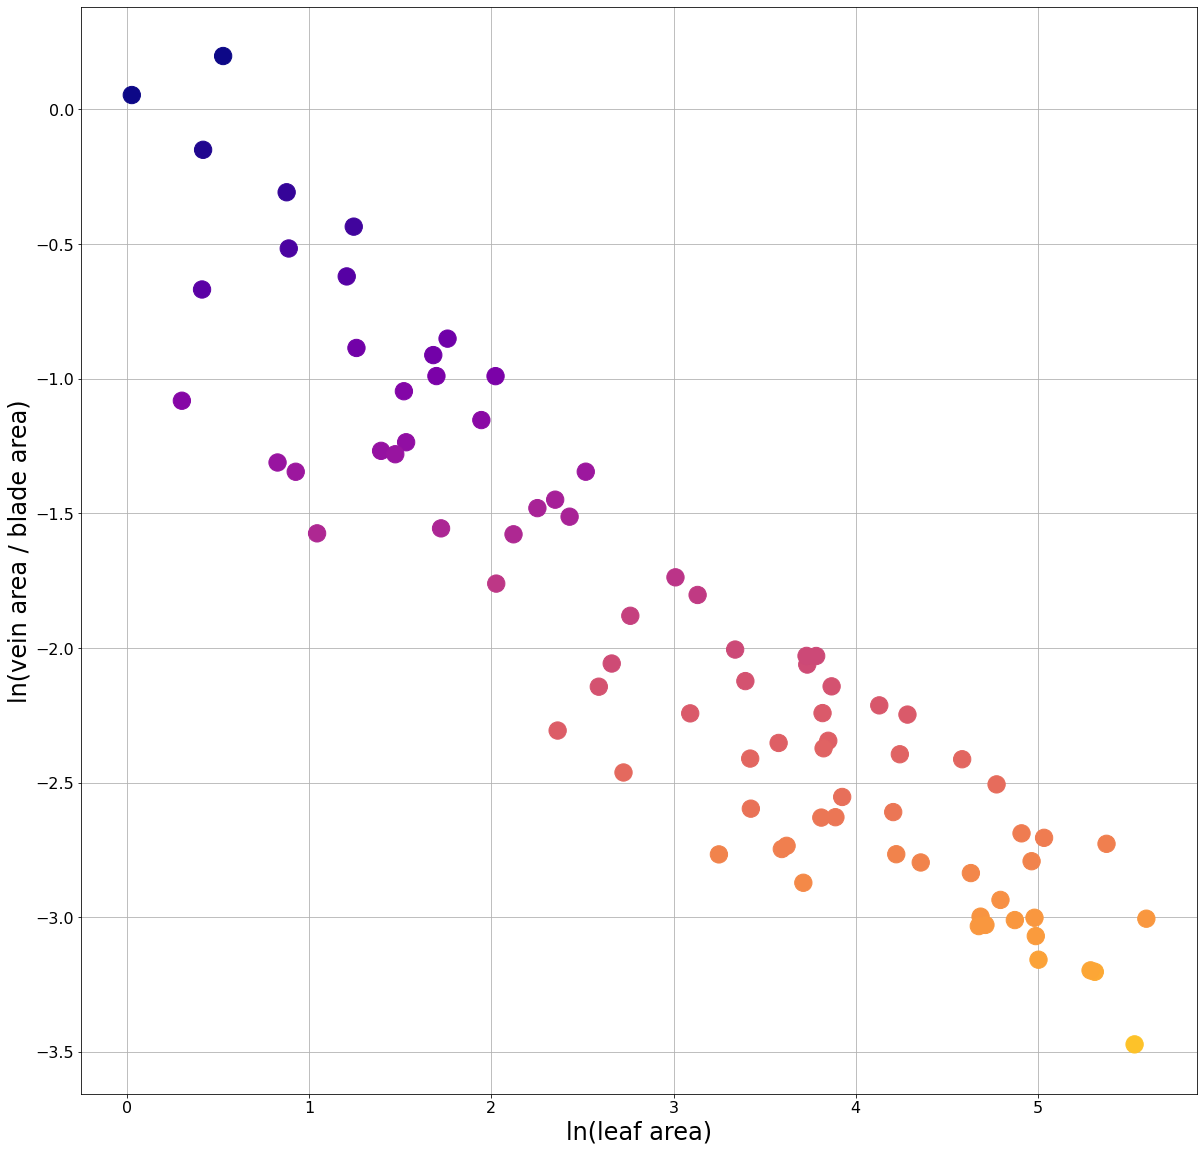

In [7]:
plt.figure(figsize=(20,20))

plt.scatter(np.log(leaf_areas), vtb_ratios, c=hex_colors, s=300)

plt.xlabel("ln(leaf area)", fontsize=24)
plt.ylabel("ln(vein area / blade area)", fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.gca().set_axisbelow(True)

plt.savefig("vein_to_blade_ratio.jpg", bbox_inches='tight')

# PROCRUSTES ANALYSIS

#### Calculate GPA mean

In [8]:
ref_ind = 0 # select a reference index to calculate procrustes distances to
ref_shape = shape_list[ref_ind] # select the reference shape

mean_diff = 10**(-30) # set a distance between means to stop the algorithm

old_mean = ref_shape # for the first comparison between means, set old_mean to an arbitrary reference shape

d = 1000000 # set d initially arbitraily high

while d > mean_diff: # set boolean criterion for Procrustes distance between mean to stop calculations
    
    arr = np.zeros( ((len(shape_list)),total_length,2) ) # empty 3D array: # samples, total number of landmarks, 2 coord vals

    for i in range(len(shape_list)): # for each leaf shape after removing outliers

        s1, s2, distance = procrustes(old_mean, shape_list[i]) # calculate procrustes adjusted shape to ref for current leaf
        arr[i] = s2 # store procrustes adjusted shape to array

    new_mean = np.mean(arr, axis=(0)) # calculate mean of all shapes adjusted to reference
    
    s1, s2, d = procrustes(old_mean, new_mean) # calculate procrustes distance of new mean to old mean
    
    print("the Procrustes distance between the old and new mean is", d) # print out difference between mean distance
    
    old_mean = new_mean # set the old_mean to the new_mea before beginning another iteration
    
high_gpa_mean = new_mean


the Procrustes distance between the old and new mean is 0.012207445925845868
the Procrustes distance between the old and new mean is 3.8002197027503075e-06
the Procrustes distance between the old and new mean is 1.8160732356205062e-09
the Procrustes distance between the old and new mean is 8.752458946265587e-13
the Procrustes distance between the old and new mean is 4.219788347220491e-16
the Procrustes distance between the old and new mean is 2.0345091567183052e-19
the Procrustes distance between the old and new mean is 9.808969095830276e-23
the Procrustes distance between the old and new mean is 4.730688084007213e-26
the Procrustes distance between the old and new mean is 2.3505844837409881e-29
the Procrustes distance between the old and new mean is 1.174029181724613e-31


#### Rotate the GPA mean leaf downward

In [9]:
# calcualte petiolar junction
pet_junc = (high_gpa_mean[0]+high_gpa_mean[64])/2

# get the current angle
current_angle = angle_between(high_gpa_mean[32], pet_junc, [ pet_junc[0]+10, pet_junc[1] ] ) 

# rotate the leaf
rotated_xvals, rotated_yvals = rotate_points(high_gpa_mean[:,0], high_gpa_mean[:,1], current_angle-0)

# recreate new rotated gpa_mean array
gpa_mean = np.column_stack((rotated_xvals, rotated_yvals))


#### Plot the rotated GPA mean leaf

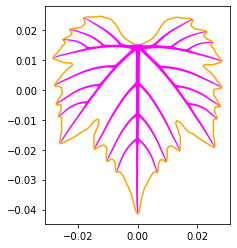

In [10]:
high_gpa_landmarks = gpa_mean[0:landmarks_len,:] # get true landmarks
high_gpa_mean_veins = gpa_mean[landmarks_len:landmarks_len+vein_len,:] # get vein landmarks
high_gpa_mean_blade = gpa_mean[landmarks_len+vein_len:,:] # get blade landmarks

plt.fill(high_gpa_mean_veins[:,0], high_gpa_mean_veins[:,1], "magenta")
plt.plot(high_gpa_mean_blade[:,0], high_gpa_mean_blade[:,1], "orange", zorder=0)
plt.gca().set_aspect("equal")

#### Calculate Procrustes coordinates for leaves

In [11]:
high_proc_arr = np.zeros( ((len(shape_list)), total_length, 2) ) # empty 3D array: # samples, total landmarks, 2 coord vals

for i in range(len(shape_list)): # for each leaf shape after removing outliers

    s1, s2, distance = procrustes(high_gpa_mean, shape_list[i]) # calculate procrustes adjusted shape to ref for current leaf
    high_proc_arr[i] = s2 # store procrustes adjusted shape to array
    

# Display measured leaves

In [12]:
for i in range(len(species_list)):
    
    name = species_list[i] # get curret name
    
    # replace name if 'AMPELOPSIS GLANDULOSA VAR BREVIPEDUNCULATA'
    # with "AMPELOPSIS GLANDULOSA"
    
    if name == 'AMPELOPSIS GLANDULOSA VAR BREVIPEDUNCULATA':
        name = "AMPELOPSIS GLANDULOSA"
        species_list[i] = name 

In [13]:
new_node_list = []

for i in range(len(node_list)):

    text = node_list[i] # get node description
    ind = text.index(",") # get position of comma
    node_text = text[:ind] # get node value
    
    new_node_list.append("node: " + node_text)

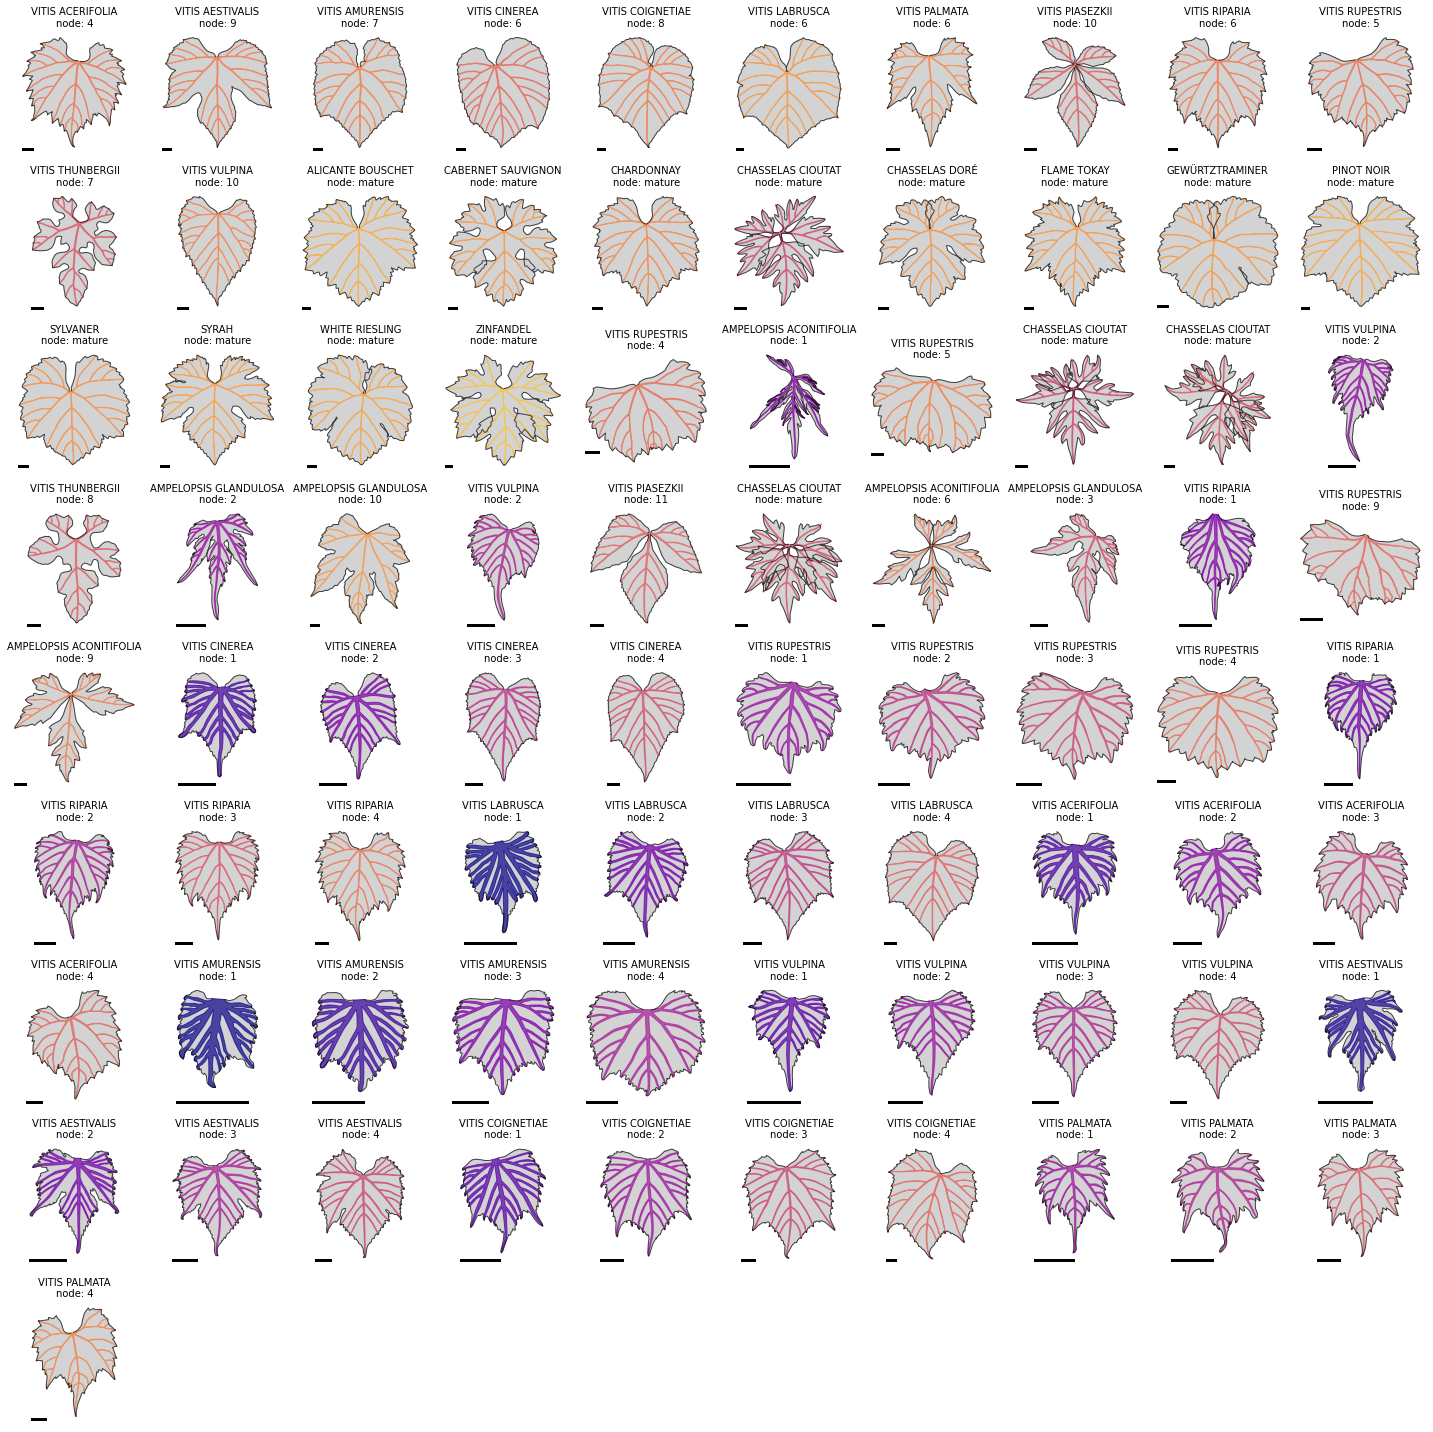

In [14]:
cmap = cm.get_cmap('plasma', 100) # set the color map

plt.figure(figsize=(20,20))

for i in range(len(leaf_list)): # for each leaf in leaf_list

    curr_leaf = leaf_list[i] # get curret leaf
    curr_label = label_list[i] # get current label

    # read in scaled landmark data from ./highres_landmarks folder
    landmarks = np.loadtxt("./highres_landmarks/" + curr_leaf + "_scaled_landmarks.txt") # landmark points
    vein_trace = np.loadtxt("./highres_landmarks/" + curr_leaf + "_scaled_veins.txt") # vein trace outline
    blade_trace = np.loadtxt("./highres_landmarks/" + curr_leaf + "_scaled_blade.txt") # blade trace outline
    
    # calculate vein-to-blade ratio
    vein_area = PolyArea(vein_trace[:,0],vein_trace[:,1])
    leaf_area = PolyArea(blade_trace[:,0],blade_trace[:,1])
    blade_area = leaf_area-vein_area
    vtb_ratio = np.log(vein_area/blade_area)
    vtb_min = -4
    norm_vtb = vtb_ratio/vtb_min
    hexcol = matplotlib.colors.rgb2hex(cmap(norm_vtb))
    
    plt.subplot(9,10,i+1)
    plt.plot(blade_trace[:,0], blade_trace[:,1], lw=1, c="k", alpha=0.7)
    plt.fill(blade_trace[:,0], blade_trace[:,1], c="lightgray")
    plt.fill(vein_trace[:,0], vein_trace[:,1], c=hexcol, alpha=0.7)
    
    # plot scale 1cm scale bar
    min_x = np.min(blade_trace[:,0])
    
    plt.plot( [min_x,min_x+1], [landmarks[32,1]-0.2,landmarks[32,1]-0.2], c="k", lw=3   )
    
    title = str(species_list[i]) + "\n" + str(new_node_list[i])
    
    plt.title(title, fontsize=10)
    plt.axis("off")
    plt.gca().set_aspect("equal")
    plt.tight_layout()
    
    
plt.savefig("display_leaves.jpg")



# Principal Component Analysis

#### Get percent variance

In [15]:
# FIRST, GET THE PERCENT VARIANCE FOR ALL PCs

######
PC_NUMBER = 81
#######

high_reshaped_arr = high_proc_arr.reshape(num_samples, total_length*2) # use the reshape function to flatten proc_arr to 2D

high_pca = PCA(n_components=PC_NUMBER) 
high_PCs = high_pca.fit_transform(high_reshaped_arr) # fit a PCA

print(high_pca.explained_variance_ratio_) # print out explained variance for each PC
print(high_pca.explained_variance_ratio_.cumsum())


[4.67013629e-01 1.22554336e-01 8.94101691e-02 6.36805176e-02
 5.30294620e-02 4.44958818e-02 2.45623293e-02 2.22999645e-02
 1.45019673e-02 1.07344499e-02 9.96497922e-03 7.57738713e-03
 7.35370726e-03 6.97444637e-03 5.60117520e-03 4.61590253e-03
 3.88219066e-03 3.54014761e-03 3.12121864e-03 2.70327630e-03
 2.63803210e-03 2.38278659e-03 2.13444553e-03 1.90348496e-03
 1.77327587e-03 1.53130934e-03 1.53005849e-03 1.37348297e-03
 1.28158101e-03 1.16625869e-03 1.06674860e-03 1.03622585e-03
 8.94386748e-04 7.71054347e-04 7.15687841e-04 6.74858911e-04
 5.98015207e-04 5.56105707e-04 5.11220479e-04 4.53407734e-04
 4.35843501e-04 4.06416863e-04 3.93328505e-04 3.67080920e-04
 3.42750165e-04 3.28443320e-04 3.18110126e-04 3.04668893e-04
 2.95614622e-04 2.75078938e-04 2.68555634e-04 2.53091709e-04
 2.38760900e-04 2.25527160e-04 2.15038546e-04 2.03840520e-04
 1.95916395e-04 1.70275172e-04 1.66519615e-04 1.59034615e-04
 1.54620587e-04 1.39381447e-04 1.37389786e-04 1.26701836e-04
 1.23753864e-04 1.135010

#### Create PCA model with desired PC number

In [16]:
# NEXT, CALCULATE THE DESIRED NUMBER OF PCs

######
PC_NUMBER = 2
#######

reshaped_arr = high_proc_arr.reshape(num_samples, total_length*2) # use the reshape function to flatten proc_arr to 2D

pca = PCA(n_components=PC_NUMBER) 
PCs = pca.fit_transform(reshaped_arr) # fit a PCA

print(pca.explained_variance_ratio_) # print out explained variance for each PC
print(pca.explained_variance_ratio_.cumsum())


[0.46701363 0.12255434]
[0.46701363 0.58956797]


#### Visualize PCA space and sample identity

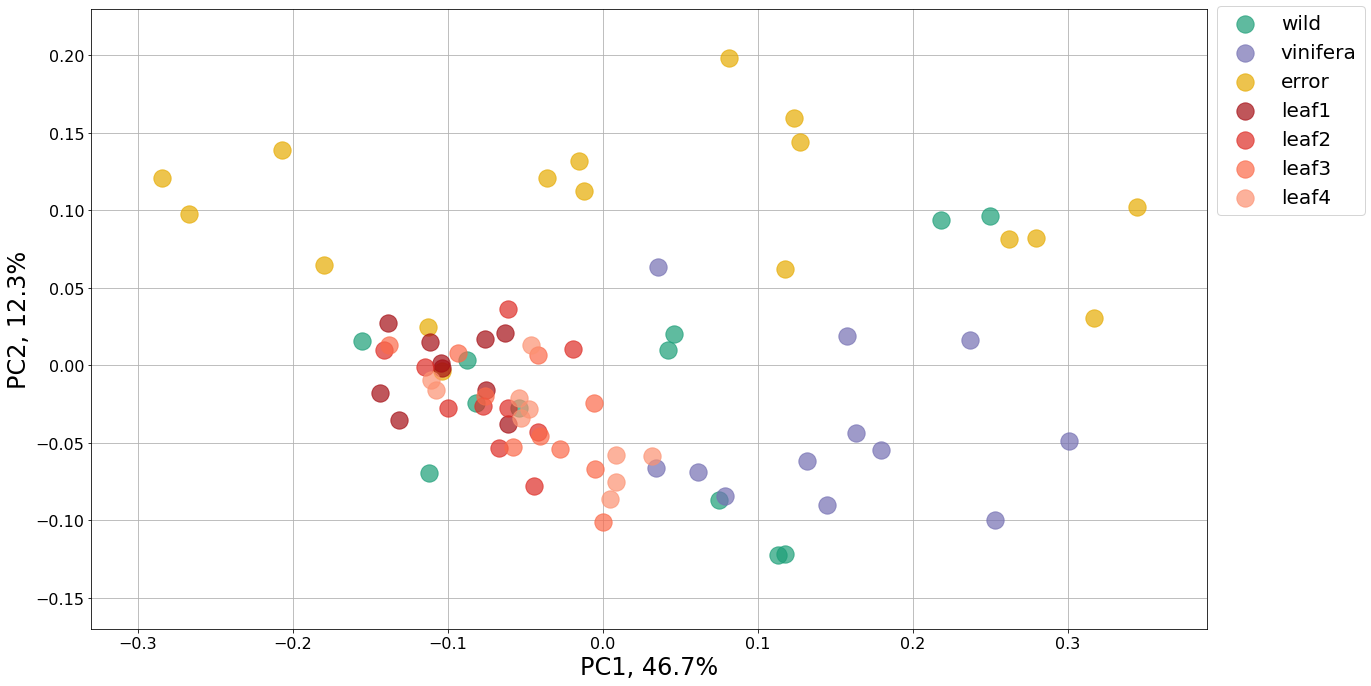

In [17]:
pointsize = 300 # set point size
a = 0.7 # set alpha

plt.figure(figsize=(20,20))

plt.scatter(PCs[0:12,0], PCs[0:12,1], label="wild", c= "#1b9e77", s=pointsize, alpha=a)
plt.scatter(PCs[12:24,0], PCs[12:24,1], label="vinifera", c= "#7570b3", s=pointsize, alpha=a)
plt.scatter(PCs[24:41,0], PCs[24:41,1], label="error", c= "#e6ab02", s=pointsize, alpha=a)
plt.scatter(PCs[41::4,0], PCs[41::4,1], label="leaf1", c= "#a50f15", s=pointsize, alpha=a)
plt.scatter(PCs[42::4,0], PCs[42::4,1], label="leaf2", c= "#de2d26", s=pointsize, alpha=a)
plt.scatter(PCs[43::4,0], PCs[43::4,1], label="leaf3", c= "#fb6a4a", s=pointsize, alpha=a)
plt.scatter(PCs[44::4,0], PCs[44::4,1], label="leaf4", c= "#fc9272", s=pointsize, alpha=a)

plt.legend(bbox_to_anchor=(1.15, 1.02), prop={'size': 20})
xlab = "PC1, " + str(np.round(pca.explained_variance_ratio_[0],3)*100) + "%"
ylab = "PC2, " + str(np.round(pca.explained_variance_ratio_[1],3)*100) + "%"


plt.xlim(-0.33,0.39)
plt.ylim(-0.17,0.23)

plt.xlabel(xlab, fontsize=24)
plt.ylabel(ylab, fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.gca().set_aspect("equal")
plt.gca().set_facecolor("white")
plt.grid()
plt.gca().set_axisbelow(True)

plt.savefig("PCA_identity.jpg", bbox_inches='tight')


#### Morphospace

In [18]:
# Get ratio of PC ranges to choose number of theoretical leaves to reconstruct

print("Ratio ranges of PC1/PC2:", (np.max(PCs[:,0])-np.min(PCs[:,0]))/
      (np.max(PCs[:,1])-np.min(PCs[:,1]))   )

Ratio ranges of PC1/PC2: 1.9635656097051462


In [19]:
# Create PC values to reconstruct

numPC1 = 10 # set PC1 intervals
numPC2 = 5 # set PC2 intervals

PC1_vals = np.linspace( np.min(PCs[:,0]), np.max(PCs[:,0]), numPC1 ) # create intervals
PC2_vals = np.linspace( np.min(PCs[:,1]), np.max(PCs[:,1]), numPC2 )

-0.28431462409790925
-0.2144132665856912
-0.14451190907347317
-0.07461055156125512
-0.00470919404903708
0.06519216346318096
0.135093520975399
0.20499487848761705
0.2748962359998351
0.3447975935120532


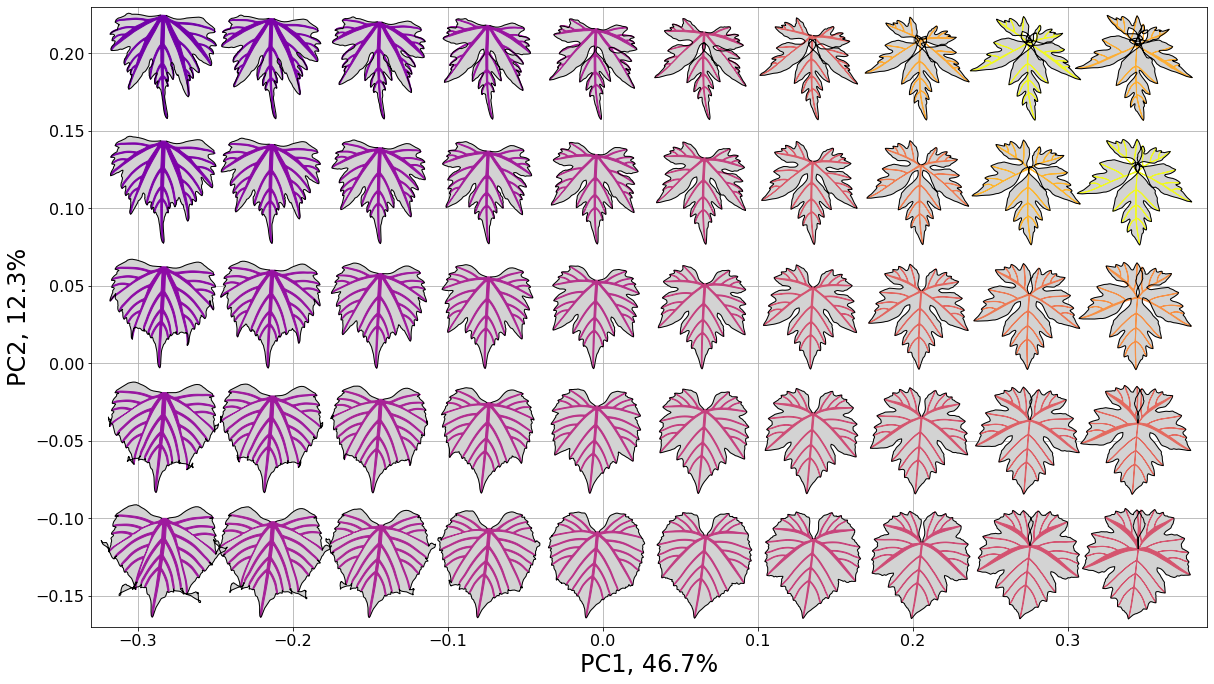

In [20]:
# Visualize the morphospace

cmap = cm.get_cmap('plasma', 100) # set the color map
s = 1.0 # set the scale

plt.figure(figsize=(20,20))

for i in PC1_vals:
    
    print(i)
    
    for j in PC2_vals:
        
        pc1_val = i
        pc2_val = j

        inv_leaf = pca.inverse_transform(np.array([pc1_val,pc2_val]))

        inv_leaf_landX = inv_leaf[0:69*2:2]
        inv_leaf_landY = inv_leaf[1:69*2:2]
        inv_leaf_veinX = inv_leaf[69*2:1285*2:2]
        inv_leaf_veinY = inv_leaf[((69*2)+1):1285*2:2]
        inv_leaf_bladeX = inv_leaf[1285*2::2]
        inv_leaf_bladeY = inv_leaf[((1285*2)+1)::2]

        vein_area = PolyArea(inv_leaf_veinX,inv_leaf_veinY)
        leaf_area = PolyArea(inv_leaf_bladeX,inv_leaf_bladeY)
        blade_area = leaf_area-vein_area
        vtb_ratio = np.log(vein_area/blade_area)
        vtb_min = -4
        norm_vtb = vtb_ratio/vtb_min
        hexcol = matplotlib.colors.rgb2hex(cmap(norm_vtb))

        plt.fill(inv_leaf_bladeX*s+pc1_val, inv_leaf_bladeY*s+pc2_val, c="lightgray")
        plt.plot(inv_leaf_bladeX*s+pc1_val, inv_leaf_bladeY*s+pc2_val, c="k", lw=1)
        plt.fill(inv_leaf_veinX*s+pc1_val, inv_leaf_veinY*s+pc2_val, c=hexcol)

plt.xlim(-0.33,0.39)
plt.ylim(-0.17,0.23)
         
xlab = "PC1, " + str(np.round(pca.explained_variance_ratio_[0],3)*100) + "%"
ylab = "PC2, " + str(np.round(pca.explained_variance_ratio_[1],3)*100) + "%"
plt.xlabel(xlab, fontsize=24)
plt.ylabel(ylab, fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.gca().set_aspect("equal")
plt.gca().set_facecolor("white")
plt.grid()
plt.gca().set_axisbelow(True)

plt.savefig("PCA_morphospace.jpg", bbox_inches='tight')

# LOW RES ANALYSIS

#### Create list of file names

In [21]:
# provide path to landmarks folder
landmarks_path = "./lowres_data/"

# retrieve a list of landmark file names
landmark_files = [f for f in listdir(landmarks_path) if isfile(join(landmarks_path, f))] 
# sort the file names alpha numerically
landmark_files.sort()

# if there is a .DS_Store file, delete it
if landmark_files[0]==".DS_Store":
    del landmark_files[0]
    

#### Read in landmark files for each leaf

In [22]:
# a list of arrays, to store 2D arrays of landmark points for each leaf
landmark_data = []

# for each shape
for i in range(len(landmark_files)):
    
    if landmark_files[i]==".DS_Store":
        continue
    
    # load in the landmark data as a 2D numpy array
    current_landmark_data = np.loadtxt(landmarks_path + "/" + landmark_files[i])
    # append the 2D array to the landmark_data list
    landmark_data.append(current_landmark_data)

#### Create PCs to compare low res leaves to

In [23]:
PC1_int = 100 # number of intervals across PC1 
PC2_int = 50 # number of intervals across PC2

PC1_intvals = np.linspace( np.min(PCs[:,0]), np.max(PCs[:,0]), PC1_int ) # create PC interval vals
PC2_intvals = np.linspace( np.min(PCs[:,1]), np.max(PCs[:,1]), PC2_int )

# create a list of PC values to compare low res leaves to
PC_values = []

for i in PC1_intvals:
    for j in PC2_intvals:
        curr_PC_values = [i,j]
        PC_values.append(curr_PC_values)



#### Create low res landmark representations of high res leaves

In [24]:
highres_landmarks_list = [] # store highres landmarks
lowres_of_highres_leaf_list = [] # store lowres landmark representation of high res leaf

landmarks_len = 69 # record the number of true landmarks

for j in range(len(PC_values)):

    # get current PC vals
    curr_PCs_array = np.array(PC_values[j])

    # perform the inverse PCA for current PC vals
    inv_shape = pca.inverse_transform( curr_PCs_array )

    # reshape the inverse data
    curr_reshaped = np.reshape(inv_shape, (-1, 2))

    # get true landmarks
    curr_high_landmarks = curr_reshaped[0:landmarks_len,:] 
    highres_landmarks_list.append(curr_high_landmarks)

    # get true landmarks
    curr_high_landmarks = curr_reshaped[0:landmarks_len,:] 
    highres_landmarks_list.append(curr_high_landmarks)

    # create the lower resolution representation of the high resolution leaf
    low_L01 = np.mean(np.array([curr_high_landmarks[1], curr_high_landmarks[3]]), axis=0)
    low_L02 = np.mean(np.array([curr_high_landmarks[4], curr_high_landmarks[6]]), axis=0)
    low_L03 = np.mean(np.array([curr_high_landmarks[7], curr_high_landmarks[9]]), axis=0)

    low_L04 = np.mean(np.array([curr_high_landmarks[12], curr_high_landmarks[14]]), axis=0)
    low_L05 = np.mean(np.array([curr_high_landmarks[15], curr_high_landmarks[17]]), axis=0)
    low_L06 = np.mean(np.array([curr_high_landmarks[18], curr_high_landmarks[20]]), axis=0)

    low_L07 = np.mean(np.array([curr_high_landmarks[23], curr_high_landmarks[25]]), axis=0)
    low_L08 = np.mean(np.array([curr_high_landmarks[26], curr_high_landmarks[28]]), axis=0)
    low_L09 = np.mean(np.array([curr_high_landmarks[29], curr_high_landmarks[31]]), axis=0)

    low_L10 = np.mean(np.array([curr_high_landmarks[39], curr_high_landmarks[41]]), axis=0)
    low_L11 = np.mean(np.array([curr_high_landmarks[36], curr_high_landmarks[38]]), axis=0)
    low_L12 = np.mean(np.array([curr_high_landmarks[33], curr_high_landmarks[35]]), axis=0)

    low_L13 = np.mean(np.array([curr_high_landmarks[50], curr_high_landmarks[52]]), axis=0)
    low_L14 = np.mean(np.array([curr_high_landmarks[47], curr_high_landmarks[49]]), axis=0)
    low_L15 = np.mean(np.array([curr_high_landmarks[44], curr_high_landmarks[46]]), axis=0)

    low_L16 = np.mean(np.array([curr_high_landmarks[61], curr_high_landmarks[63]]), axis=0)
    low_L17 = np.mean(np.array([curr_high_landmarks[58], curr_high_landmarks[60]]), axis=0)
    low_L18 = np.mean(np.array([curr_high_landmarks[55], curr_high_landmarks[57]]), axis=0)

    low_L19 = curr_high_landmarks[2]
    low_L20 = curr_high_landmarks[5]
    low_L21 = curr_high_landmarks[8]

    low_L22 = curr_high_landmarks[13]
    low_L23 = curr_high_landmarks[16]
    low_L24 = curr_high_landmarks[19]

    low_L25 = curr_high_landmarks[24]
    low_L26 = curr_high_landmarks[27]
    low_L27 = curr_high_landmarks[30]

    low_L28 = curr_high_landmarks[40]
    low_L29 = curr_high_landmarks[37]
    low_L30 = curr_high_landmarks[34]

    low_L31 = curr_high_landmarks[51]
    low_L32 = curr_high_landmarks[48]
    low_L33 = curr_high_landmarks[45]

    low_L34 = curr_high_landmarks[62]
    low_L35 = curr_high_landmarks[59]
    low_L36 = curr_high_landmarks[56]

    low_L37 = curr_high_landmarks[10]
    low_L38 = curr_high_landmarks[65]
    low_L39 = curr_high_landmarks[21]
    low_L40 = curr_high_landmarks[66]
    low_L41 = curr_high_landmarks[32]
    low_L42 = curr_high_landmarks[67]
    low_L43 = curr_high_landmarks[43]
    low_L44 = curr_high_landmarks[68]
    low_L45 = curr_high_landmarks[54]

    low_L46 = np.mean(np.array([curr_high_landmarks[0], curr_high_landmarks[64]]), axis=0)

    low_representation = np.array([low_L01, low_L02, low_L03, low_L04, low_L05, low_L06, low_L07, low_L08, low_L09, low_L10,
                                   low_L11, low_L12, low_L13, low_L14, low_L15, low_L16, low_L17, low_L18, low_L19, low_L20,
                                   low_L21, low_L22, low_L23, low_L24, low_L25, low_L26, low_L27, low_L28, low_L29, low_L30,
                                   low_L31, low_L32, low_L33, low_L34, low_L35, low_L36, low_L37, low_L38, low_L39, low_L40,
                                   low_L41, low_L42, low_L43, low_L44, low_L45, low_L46])

    lowres_of_highres_leaf_list.append(low_representation)



#### For each low res leaf, find best matching high res leaf PC coordinates

In [25]:
# a list to store best match low res representation of high res leaf
best_match_leaves = []

# a list to store best match high res PCs for each low res leaf
best_match_PCs = []

for i in range(np.shape(landmark_data)[0]): # for the number of low res leaves
    
    if i%20 == 0:
        print(i)
    
    # get current low res leaf
    curr_low_res_leaf = landmark_data[i]
    
    # store distance values of current leaf to PC vals
    curr_leaf_distances = []
    
    for j in lowres_of_highres_leaf_list: # for each low res represetation of a high res leaf
        
        # get the low res represntation of current high res leaf
        curr_lowres_of_highres_leaf = j
        
        # calculate procrustes distance for current leaf to low res representation
        s1, s2, distance = procrustes(curr_low_res_leaf, curr_lowres_of_highres_leaf) 

        # append distance to list for current PC
        curr_leaf_distances.append(distance)
        
    # find index of minimum distance
    min_index = curr_leaf_distances.index(min(curr_leaf_distances))
    
    # retrieve best match low res representaiton of a high res leaf based on index
    best_match_leaf = lowres_of_highres_leaf_list[min_index]
    
    # store best match leaf for current low res leaf
    best_match_leaves.append(best_match_leaf)   
    
    # store best match PCs for current leaf
    best_match_PCs.append(PC_values[min_index])
    
# create an array of best matach PCs
best_match_PC_arr = np.array(best_match_PCs)
    

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880


#### Retrieve metadata for low res leaves

In [26]:
leaf_data = pd.read_csv("./leaf_data.csv") # read in leaf data

# get node and shoot length data

nodes = [] # list to store node
counts = [] # list to store overall shoot count
datasets = [] # list to store dataset

for i in range(len(landmark_files)):
    
    curr_leaf = landmark_files[i] # get current let
    
    underscore_ind = curr_leaf.index("_") + 1 # get indices of file name data
    period_ind = curr_leaf.index(".")

    value = curr_leaf[underscore_ind:period_ind] # extract the node value

    if value == "S": # to remove DS.Store, if present

        del leaf_names[i]

    elif value == "a": # if from the vinifera dataset, set node to 0
        value = 0
    elif value == "b":
        value = 0
    elif value == "c":
        value = 0
    elif value == "d":
        value = 0
        
    nodes.append(value) # append node value
    
    image = curr_leaf[:underscore_ind-1] # get image name
    
    count = leaf_data["count"][leaf_data["image"]==image].tolist() # get count data
    
    counts.append(count) # append count data
    
    dataset = leaf_data["dataset"][leaf_data["image"]==image].tolist()[0] # get dataset value
    
    datasets.append(dataset) # append dataset values
    
relative_nodes = [] # store relative node value
categorical_node = [] # store categorical node value

for i in range(len(nodes)):

    node = float(nodes[i])
    count = float(counts[i][0])

    relative_node = node/count
    
    if relative_node == 0:
        relative_node = np.nan
    
    relative_nodes.append(relative_node)
    
    if relative_node == 0:
        early_mature = "middle"
    elif relative_node <= 0.333: # set categorical node values
        early_mature = "tip"
    else:
        early_mature = "mature"
        
    categorical_node.append(early_mature)
    
# create dataframe for plotting in seaborn

df = pd.DataFrame(list(zip(best_match_PC_arr[:,0],best_match_PC_arr[:,1])), columns=["PC1","PC2"])
df["rel_node"] = relative_nodes
df["early_mature"] = categorical_node
df["dataset"] = datasets
    

#### Visualize low res leaves to their matches in high res space by development

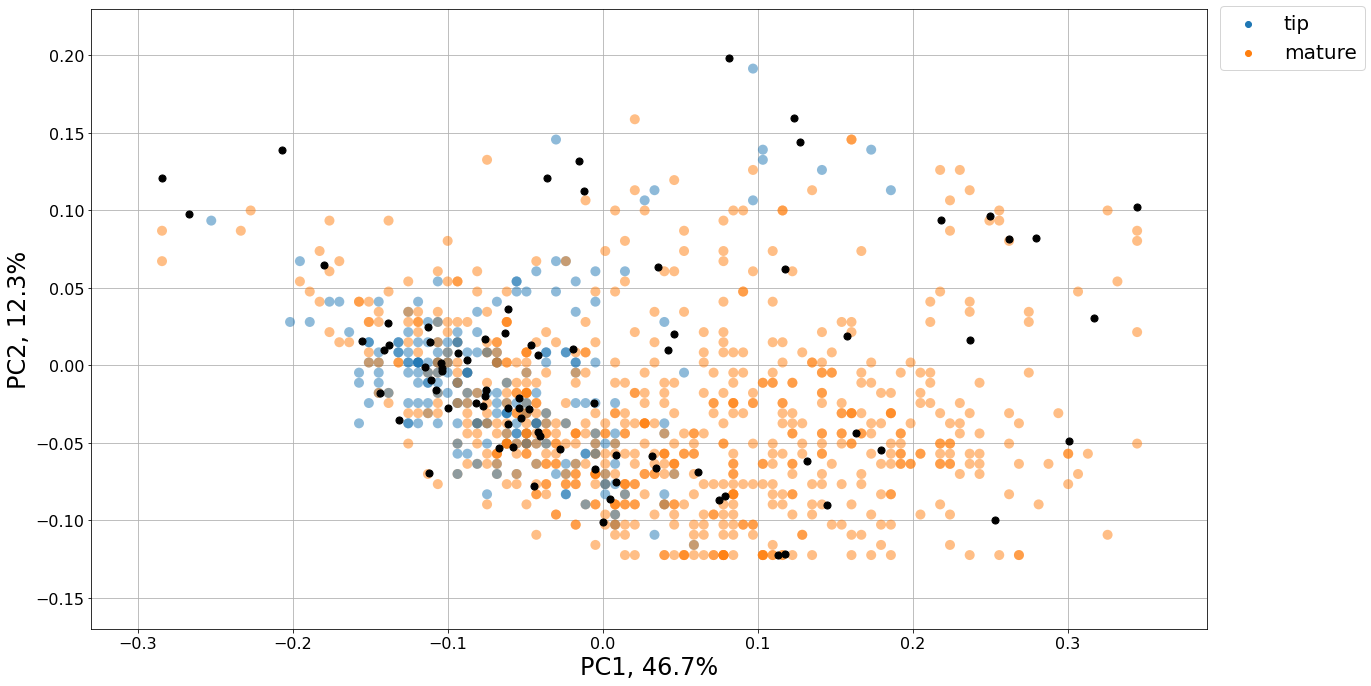

In [27]:
pointsize = 50 # set highres point size
a = 1 # set highres alpha
lowres_ps = 100 # set lowres match point size
lowres_a = 0.5 # set lowres match alpha

plt.figure(figsize=(20,20))

# plot lowres points by developmental stage
sns.scatterplot(data=df, x="PC1", y="PC2", hue="early_mature",
                linewidth=0, s= lowres_ps, alpha=lowres_a)
plt.legend(bbox_to_anchor=(1.15, 1.02), prop={'size': 20})

# plot highres points
plt.scatter(PCs[:,0], PCs[:,1], c= "k", s=pointsize, alpha=a)

xlab = "PC1, " + str(np.round(pca.explained_variance_ratio_[0],3)*100) + "%"
ylab = "PC2, " + str(np.round(pca.explained_variance_ratio_[1],3)*100) + "%"

plt.xlim(-0.33,0.39)
plt.ylim(-0.17,0.23)

plt.xlabel(xlab, fontsize=24)
plt.ylabel(ylab, fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.gca().set_aspect("equal")
plt.gca().set_facecolor("white")
plt.grid()
plt.gca().set_axisbelow(True)

plt.savefig("low_res_match_devo.jpg", bbox_inches='tight')


#### Visualize low res leaves to their matches in high res space by germplasm

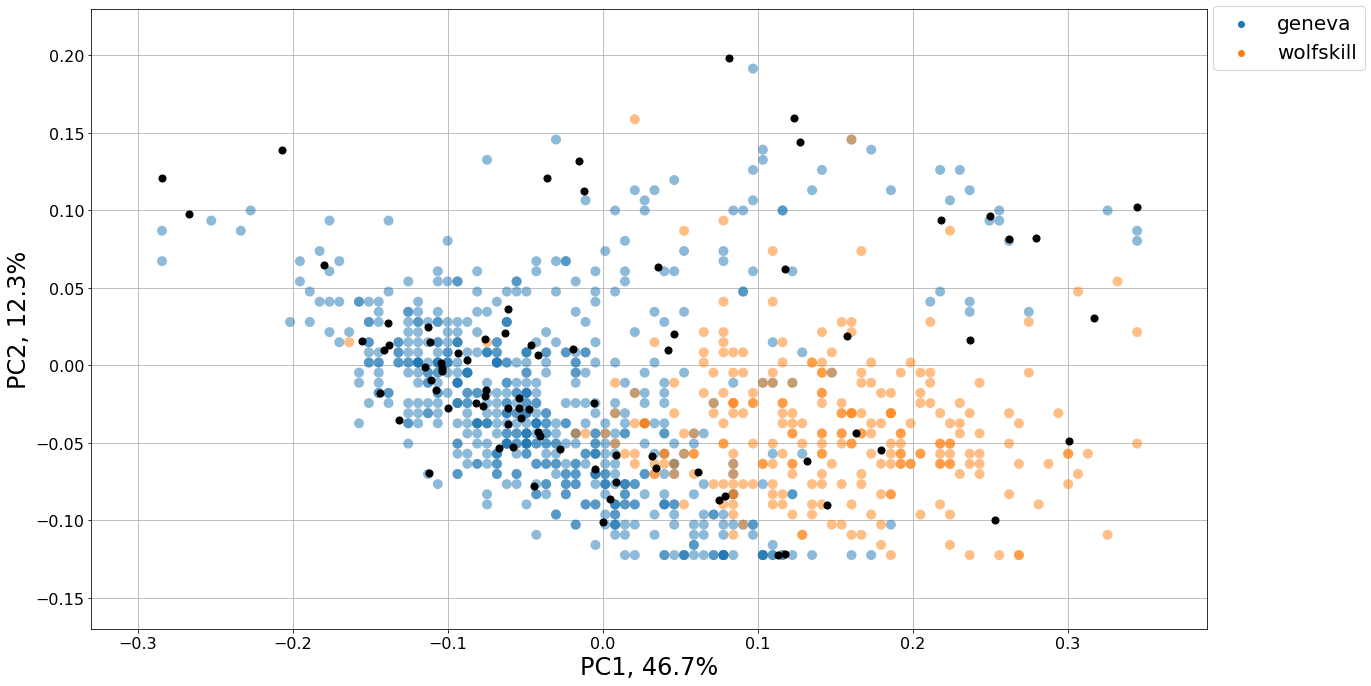

In [28]:
pointsize = 50 # set highres point size
a = 1 # set highres alpha
lowres_ps = 100 # set lowres match point size
lowres_a = 0.5 # set lowres match alpha

plt.figure(figsize=(20,20))

# plot lowres points by developmental stage
sns.scatterplot(data=df, x="PC1", y="PC2", hue="dataset",
                linewidth=0, s= lowres_ps, alpha=lowres_a)
plt.legend(bbox_to_anchor=(1.15, 1.02), prop={'size': 20})

# plot highres points
plt.scatter(PCs[:,0], PCs[:,1], c= "k", s=pointsize, alpha=a)

xlab = "PC1, " + str(np.round(pca.explained_variance_ratio_[0],3)*100) + "%"
ylab = "PC2, " + str(np.round(pca.explained_variance_ratio_[1],3)*100) + "%"

plt.xlim(-0.33,0.39)
plt.ylim(-0.17,0.23)

plt.xlabel(xlab, fontsize=24)
plt.ylabel(ylab, fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.gca().set_aspect("equal")
plt.gca().set_facecolor("white")
plt.grid()
plt.gca().set_axisbelow(True)

plt.savefig("low_res_match_germplasm.jpg", bbox_inches='tight')

# Time series 

#### Create a list with time series file info

In [29]:
# List of 1) species, 2) vine, and 3) numbering
# for measured time series data

time_series_list = [
    
["VITIS CINEREA", "588154a", "018", "019", "020", "021"],
["VITIS RUPESTRIS", "588174a", "022", "023", "024", "025"],
["VITIS RIPARIA", "313922a", "026", "027", "028", "029"],
["VITIS LABRUSCA", "483146a", "030", "031", "032", "033"],
["VITIS ACERIFOLIA", "588393a", "034", "035", "036", "037"],
["VITIS AMURENSIS", "588631a", "038", "039", "040", "041"],
["VITIS VULPINA", "483187a", "042", "043", "044", "045"],
["VITIS AESTIVALIS", "483138a", "046", "047", "048", "049"],
["VITIS COIGNETIAE", "w588451a", "050", "051", "052", "053"],
["VITIS PALMATA", "588233a", "054", "055", "056", "057"]
    
]


#### Create models of development

In [30]:
######################
### SET PARAMETERS ###
######################

poly_order = 2 # polynomial model order
intervals = 100 # number of intervals to model over

################################################
### LOOP OVER EACH SPECIES THERE IS DATA FOR ###
################################################

actual_arrays = [] # a list of arrays of actual size modeled leaves
procrustes_arrays = [] # a list of arrays of procrustes modeled leaves
pc_val_arrays = [] # a list of arrays of PC coordinates of leaves
list_of_species = [] # a list of species

for spe in range(len(time_series_list)):

    # get file info
    curr_species = time_series_list[spe] 

    #####################
    ### GET FILE INFO ###
    #####################

    species = curr_species[0]
    list_of_species.append(species)
    print(species)
    
    file = curr_species[1]
    lf1 = curr_species[2]
    lf2 = curr_species[3]
    lf3 = curr_species[4]
    lf4 = curr_species[5]

    ####################
    ### LOAD IN DATA ###
    ####################

    leaf1_landmarks = np.loadtxt("./highres_landmarks/"+lf1+"_leaf1_"+file+"_scaled_landmarks.txt")
    leaf2_landmarks = np.loadtxt("./highres_landmarks/"+lf2+"_leaf2_"+file+"_scaled_landmarks.txt")
    leaf3_landmarks = np.loadtxt("./highres_landmarks/"+lf3+"_leaf3_"+file+"_scaled_landmarks.txt")
    leaf4_landmarks = np.loadtxt("./highres_landmarks/"+lf4+"_leaf4_"+file+"_scaled_landmarks.txt")

    leaf1_veins = np.loadtxt("./highres_landmarks/"+lf1+"_leaf1_"+file+"_scaled_veins.txt")
    leaf2_veins = np.loadtxt("./highres_landmarks/"+lf2+"_leaf2_"+file+"_scaled_veins.txt")
    leaf3_veins = np.loadtxt("./highres_landmarks/"+lf3+"_leaf3_"+file+"_scaled_veins.txt")
    leaf4_veins = np.loadtxt("./highres_landmarks/"+lf4+"_leaf4_"+file+"_scaled_veins.txt")

    leaf1_blade = np.loadtxt("./highres_landmarks/"+lf1+"_leaf1_"+file+"_scaled_blade.txt")
    leaf2_blade = np.loadtxt("./highres_landmarks/"+lf2+"_leaf2_"+file+"_scaled_blade.txt")
    leaf3_blade = np.loadtxt("./highres_landmarks/"+lf3+"_leaf3_"+file+"_scaled_blade.txt")
    leaf4_blade = np.loadtxt("./highres_landmarks/"+lf4+"_leaf4_"+file+"_scaled_blade.txt")

    ###########################################
    ### COMBINE LANDMARKS, VEINS, AND BLADE ###
    ###########################################

    # THE INDICES ARE
    # index of landmarks is 0:69
    # index of veins is 69:1285
    # index of blade is 1285:

    leaf1 = np.row_stack((leaf1_landmarks, leaf1_veins, leaf1_blade))
    leaf2 = np.row_stack((leaf2_landmarks, leaf2_veins, leaf2_blade))
    leaf3 = np.row_stack((leaf3_landmarks, leaf3_veins, leaf3_blade))
    leaf4 = np.row_stack((leaf4_landmarks, leaf4_veins, leaf4_blade))

    # combine arrays for each leaf into a list
    shape_list = [leaf1, leaf2, leaf3, leaf4]

    # combine arrays for each leaf into an array
    shape_arr = np.array((leaf1, leaf2, leaf3, leaf4))

    #########################################################
    ### MODEL NON-PROCRUSTES, ACTUAL SIZE LANDMARK VALUES ###
    #########################################################

    total_length = len(leaf1) # the number of landmarks to consider

    # an array to hold the  modeled data
    # 100 intervals x 1817 landmarks x 2 coords
    actual_arr = np.zeros((intervals,total_length,2))

    for i in range(total_length): # for i landmark in 1817

        for j in range(2): # for j coordinates in x and y, 0 and 1

            # fit function across values 1, 2, 3, and 4 for current i, j landmark coord val
            N = np.polyfit( np.array([1,2,3,4]), shape_arr[:, i, j], poly_order )
            func = np.poly1d(N)

            # model vals over interval numbers for leaves 1 through 4
            model_vals = func(np.linspace(1,4,intervals))

            # place modeled values into array
            actual_arr[0:100, i, j] = model_vals
            
    actual_arrays.append(actual_arr) # store actual size leaves

    ########################################
    ### CALCULATE PROCRUSTES COORDINATES ###
    ########################################

    proc_arr = np.zeros( ((len(shape_list)), total_length, 2) ) # empty 3D array: # samples, total landmarks, 2 coord vals

    for i in range(len(shape_list)): # for each leaf shape after removing outliers

        s1, s2, distance = procrustes(gpa_mean, shape_list[i]) # calculate procrustes adjusted shape to ref for current leaf
        proc_arr[i] = s2 # store procrustes adjusted shape to array

    ########################################
    ### MODEL PROCRUSTES LANDMARK VALUES ###
    ########################################

    # an array to hold the  modeled data
    # 100 intervals x 1817 landmarks x 2 coords
    arr = np.zeros((intervals,total_length,2))

    for i in range(total_length): # for i landmark in 1817

        for j in range(2): # for j coordinates in x and y, 0 and 1

            # fit function across values 1, 2, 3, and 4 for current i, j landmark coord val
            N = np.polyfit( np.array([1,2,3,4]), proc_arr[:, i, j], poly_order )
            func = np.poly1d(N)

            # model vals over interval numbers for leaves 1 through 4
            model_vals = func(np.linspace(1,4,intervals))

            # place modeled values into array
            arr[0:100, i, j] = model_vals
            
    procrustes_arrays.append(arr) # store procrustes coordinates

    ##########################################
    ### PROJECT PROCRUSTES SHAPES ONTO PCA ###
    ##########################################

    # an array to hold the PCA values
    # 100 leaf models x 2 coords
    pc_arr = np.zeros((intervals,2))

    for i in range(intervals): # for each modeled leaf

        # get PCA coordinates of the leaf
        transform = pca.transform(np.reshape(arr[i], (1,3634))) 
        # append to pc_arr
        pc_arr[i, :] = transform
        
    pc_val_arrays.append(pc_arr) # store PC values
    

VITIS CINEREA
VITIS RUPESTRIS
VITIS RIPARIA
VITIS LABRUSCA
VITIS ACERIFOLIA
VITIS AMURENSIS
VITIS VULPINA
VITIS AESTIVALIS
VITIS COIGNETIAE
VITIS PALMATA


#### Project developmental models onto the PCA

list

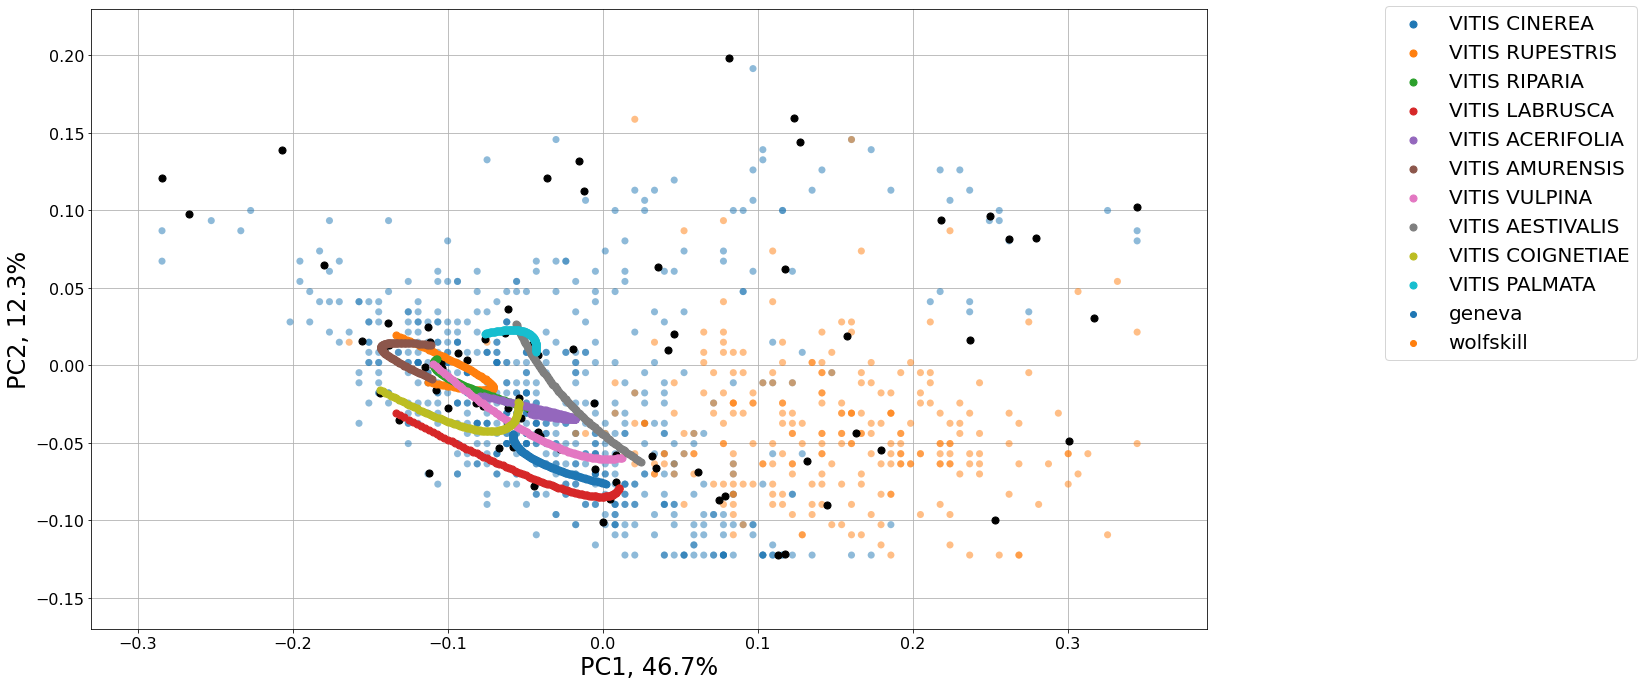

In [31]:
pointsize = 50 # set highres point size
a = 1 # set highres alpha
lowres_ps = 50 # set lowres match point size
lowres_a = 0.5 # set lowres match alpha

plt.figure(figsize=(20,20))

for i in range(len(pc_val_arrays)):
    
    curr_species = pc_val_arrays[i]
    plt.scatter(curr_species[:,0], curr_species[:,1], label=list_of_species[i], zorder=4, s=50)
    
# plot lowres points by developmental stage
sns.scatterplot(data=df, x="PC1", y="PC2", hue="dataset",
                linewidth=0, s= lowres_ps, alpha=lowres_a)
plt.legend(bbox_to_anchor=(1.15, 1.02), prop={'size': 20})

# plot highres points
plt.scatter(PCs[:,0], PCs[:,1], c= "k", s=pointsize, alpha=a)

xlab = "PC1, " + str(np.round(pca.explained_variance_ratio_[0],3)*100) + "%"
ylab = "PC2, " + str(np.round(pca.explained_variance_ratio_[1],3)*100) + "%"

plt.xlim(-0.33,0.39)
plt.ylim(-0.17,0.23)

plt.xlabel(xlab, fontsize=24)
plt.ylabel(ylab, fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.gca().set_aspect("equal")
plt.gca().set_facecolor("white")
plt.grid()
plt.gca().set_axisbelow(True)

plt.savefig("PCA_developmental_models.jpg", bbox_inches='tight')
list

In [32]:
list_of_species

['VITIS CINEREA',
 'VITIS RUPESTRIS',
 'VITIS RIPARIA',
 'VITIS LABRUSCA',
 'VITIS ACERIFOLIA',
 'VITIS AMURENSIS',
 'VITIS VULPINA',
 'VITIS AESTIVALIS',
 'VITIS COIGNETIAE',
 'VITIS PALMATA']

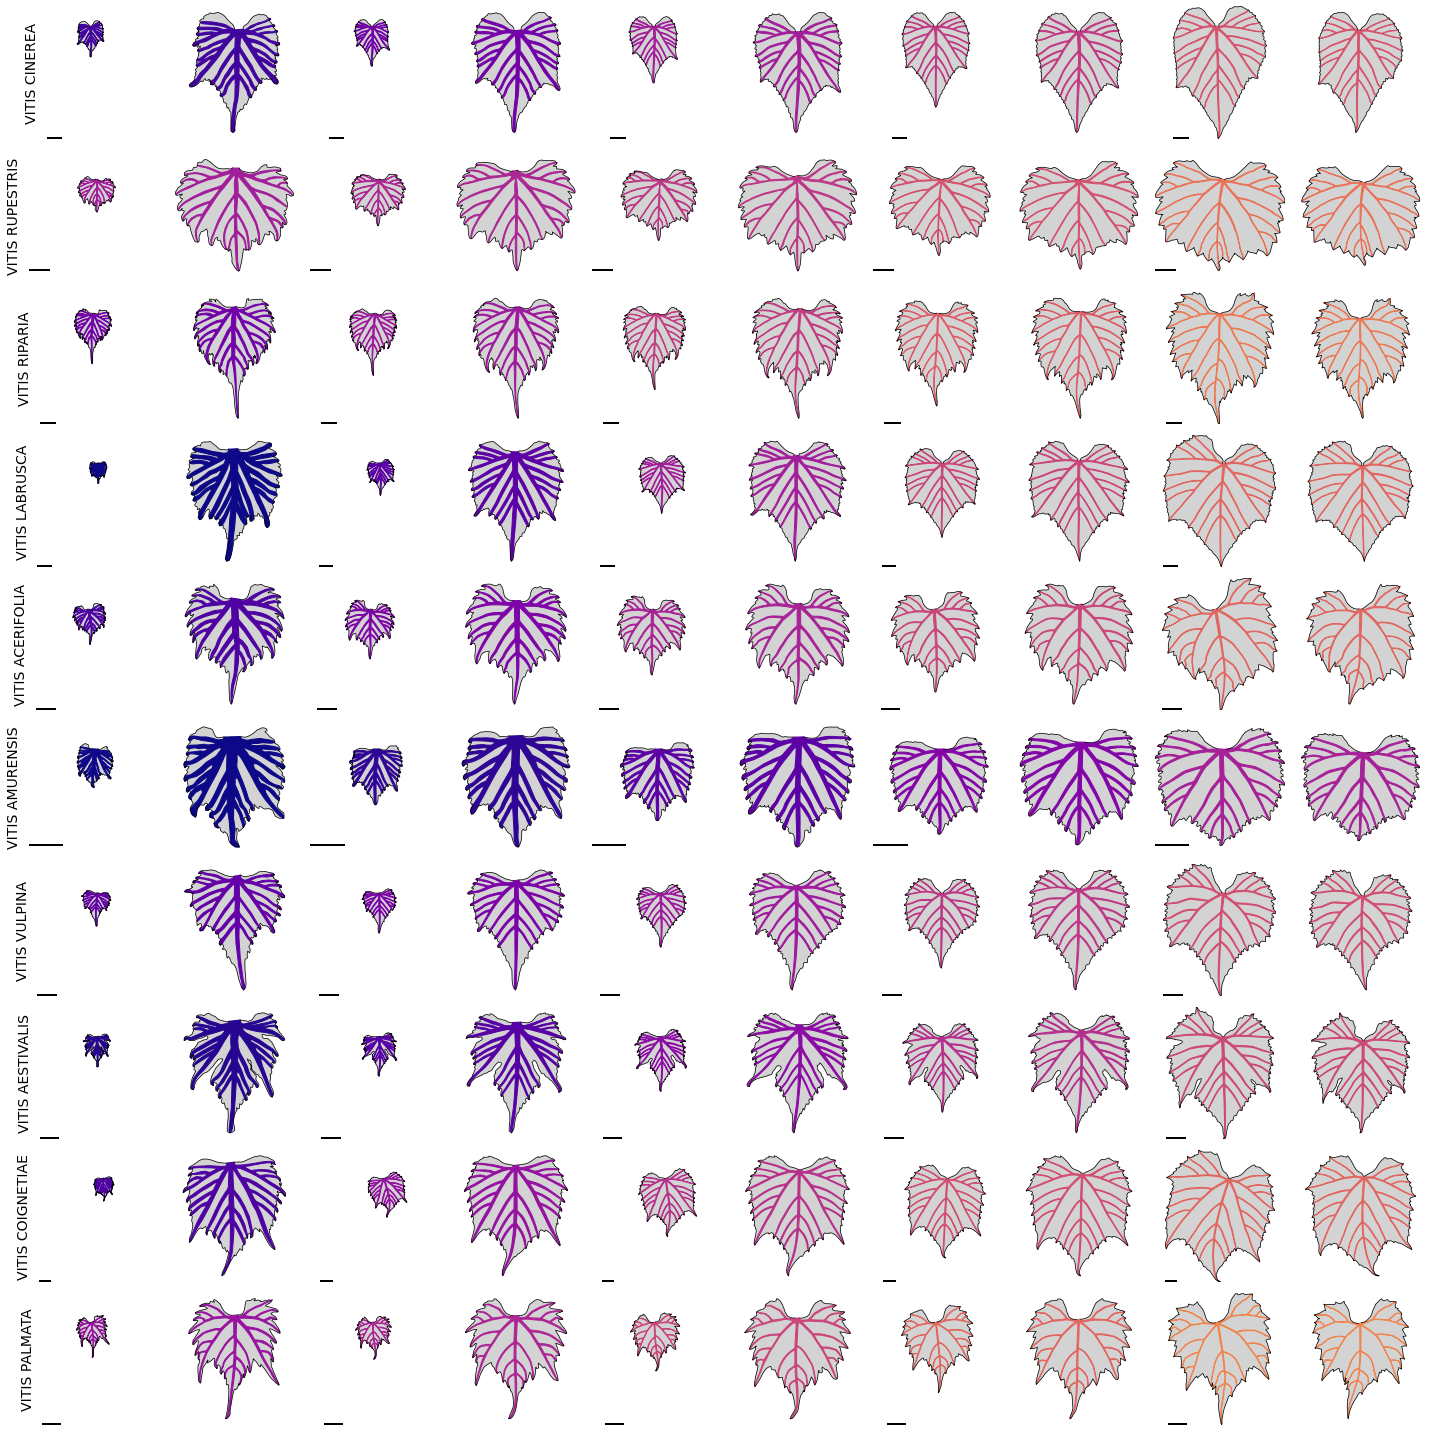

In [33]:
# THE INDICES ARE
# index of landmarks is 0:69
# index of veins is 69:1285
# index of blade is 1285:

indices = [0,24,49,74,99] # set the indices to plot
bar_size = 5 # centimeter bar lw
vtb_min = -4 # set value to normalize vein to blade ratio color
blade_col = "lightgray" # set blade color
blade_lw = 0.7 # width of blade outline
name_size = 14 # set fontsize of species names

plt.figure(figsize=(20,20))

for i in range(len(list_of_species)):

    curr_species = list_of_species[i] # get species name
    curr_actual = actual_arrays[i] # get current species actual size
    curr_procrustes = procrustes_arrays[i] # get current species procrustes

    xmin = np.min(curr_actual[:,:,0])
    xmax = np.max(curr_actual[:,:,0])
    ymin = np.min(curr_actual[:,:,1])
    ymax = np.max(curr_actual[:,:,1])

    cmap = cm.get_cmap('plasma', 100) # set the color map

    # get the indices
    ind1 = indices[0]
    ind2 = indices[1]
    ind3 = indices[2]
    ind4 = indices[3]
    ind5 = indices[4]

    # get actual leaves
    actual_1 = curr_actual[ind1]
    actual_V1 = actual_1[69:1285]
    actual_B1 = actual_1[1285:]

    actual_2 = curr_actual[ind2]
    actual_V2 = actual_2[69:1285]
    actual_B2 = actual_2[1285:]

    actual_3 = curr_actual[ind3]
    actual_V3 = actual_3[69:1285]
    actual_B3 = actual_3[1285:]

    actual_4 = curr_actual[ind4]
    actual_V4 = actual_4[69:1285]
    actual_B4 = actual_4[1285:]

    actual_5 = curr_actual[ind5]
    actual_V5 = actual_5[69:1285]
    actual_B5 = actual_5[1285:]

    # get procrustes leaves
    procrustes_1 = curr_procrustes[ind1]
    procrustes_V1 = procrustes_1[69:1285]
    procrustes_B1 = procrustes_1[1285:]

    procrustes_2 = curr_procrustes[ind2]
    procrustes_V2 = procrustes_2[69:1285]
    procrustes_B2 = procrustes_2[1285:]

    procrustes_3 = curr_procrustes[ind3]
    procrustes_V3 = procrustes_3[69:1285]
    procrustes_B3 = procrustes_3[1285:]

    procrustes_4 = curr_procrustes[ind4]
    procrustes_V4 = procrustes_4[69:1285]
    procrustes_B4 = procrustes_4[1285:]

    procrustes_5 = curr_procrustes[ind5]
    procrustes_V5 = procrustes_5[69:1285]
    procrustes_B5 = procrustes_5[1285:]

    # get vein to blade ratio of each leaf

    area_1 = PolyArea(actual_B1[:,0], actual_B1[:,1])
    vein_1 = PolyArea(actual_V1[:,0], actual_V1[:,1])
    blade_1 = area_1-vein_1
    vtb_1 = np.log(vein_1/blade_1)
    nvtb_1 = vtb_1/vtb_min
    hexcol_1 = matplotlib.colors.rgb2hex(cmap(nvtb_1))

    area_2 = PolyArea(actual_B2[:,0], actual_B2[:,1])
    vein_2 = PolyArea(actual_V2[:,0], actual_V2[:,1])
    blade_2 = area_2-vein_2
    vtb_2 = np.log(vein_2/blade_2)
    nvtb_2 = vtb_2/vtb_min
    hexcol_2 = matplotlib.colors.rgb2hex(cmap(nvtb_2))

    area_3 = PolyArea(actual_B3[:,0], actual_B3[:,1])
    vein_3 = PolyArea(actual_V3[:,0], actual_V3[:,1])
    blade_3 = area_3-vein_3
    vtb_3 = np.log(vein_3/blade_3)
    nvtb_3 = vtb_3/vtb_min
    hexcol_3 = matplotlib.colors.rgb2hex(cmap(nvtb_3))

    area_4 = PolyArea(actual_B4[:,0], actual_B4[:,1])
    vein_4 = PolyArea(actual_V4[:,0], actual_V4[:,1])
    blade_4 = area_4-vein_4
    vtb_4 = np.log(vein_4/blade_4)
    nvtb_4 = vtb_4/vtb_min
    hexcol_4 = matplotlib.colors.rgb2hex(cmap(nvtb_4))

    area_5 = PolyArea(actual_B5[:,0], actual_B5[:,1])
    vein_5 = PolyArea(actual_V5[:,0], actual_V5[:,1])
    blade_5 = area_5-vein_5
    vtb_5 = np.log(vein_5/blade_5)
    nvtb_5 = vtb_5/vtb_min
    hexcol_5 = matplotlib.colors.rgb2hex(cmap(nvtb_5))

    ###############
    ### INDEX 1 ###
    ###############

    plt.subplot(10,10, i*10+1)
    plt.fill(actual_B1[:,0], actual_B1[:,1], c=blade_col)
    plt.plot(actual_B1[:,0], actual_B1[:,1], c="k", lw=blade_lw)
    plt.fill(actual_V1[:,0], actual_V1[:,1], c=hexcol_1)
    plt.plot([xmin, xmin+1], [ymin,ymin], c="k", lw=bar_size)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.ylabel(curr_species, fontsize=name_size)
    plt.gca().set_yticklabels([])
    plt.gca().set_xticklabels([])
    plt.gca().set_yticks([])
    plt.gca().set_xticks([])
    plt.gca().spines[['right', 'top', "left", "bottom"]].set_visible(False)
    plt.gca().set_aspect("equal")
    

    plt.subplot(10,10, i*10+2)
    plt.fill(procrustes_B1[:,0], procrustes_B1[:,1], c=blade_col)
    plt.plot(procrustes_B1[:,0], procrustes_B1[:,1], c="k", lw=blade_lw)
    plt.fill(procrustes_V1[:,0], procrustes_V1[:,1], c=hexcol_1)
    plt.axis("off")
    plt.gca().set_aspect("equal")
    

    ###############
    ### INDEX 2 ###
    ###############

    plt.subplot(10,10, i*10+3)
    plt.fill(actual_B2[:,0], actual_B2[:,1], c=blade_col)
    plt.plot(actual_B2[:,0], actual_B2[:,1], c="k", lw=blade_lw)
    plt.fill(actual_V2[:,0], actual_V2[:,1], c=hexcol_2)
    plt.plot([xmin, xmin+1], [ymin,ymin], c="k", lw=bar_size)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.gca().set_yticklabels([])
    plt.gca().set_xticklabels([])
    plt.gca().set_yticks([])
    plt.gca().set_xticks([])
    plt.gca().spines[['right', 'top', "left", "bottom"]].set_visible(False)
    plt.gca().set_aspect("equal")
    

    plt.subplot(10,10, i*10+4)
    plt.fill(procrustes_B2[:,0], procrustes_B2[:,1], c=blade_col)
    plt.plot(procrustes_B2[:,0], procrustes_B2[:,1], c="k", lw=blade_lw)
    plt.fill(procrustes_V2[:,0], procrustes_V2[:,1], c=hexcol_2)
    plt.axis("off")
    plt.gca().set_aspect("equal")
    

    ###############
    ### INDEX 3 ###
    ###############

    plt.subplot(10,10, i*10+5)
    plt.fill(actual_B3[:,0], actual_B3[:,1], c=blade_col)
    plt.plot(actual_B3[:,0], actual_B3[:,1], c="k", lw=blade_lw)
    plt.fill(actual_V3[:,0], actual_V3[:,1], c=hexcol_3)
    plt.plot([xmin, xmin+1], [ymin,ymin], c="k", lw=bar_size)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.gca().set_yticklabels([])
    plt.gca().set_xticklabels([])
    plt.gca().set_yticks([])
    plt.gca().set_xticks([])
    plt.gca().spines[['right', 'top', "left", "bottom"]].set_visible(False)
    plt.gca().set_aspect("equal")
    

    plt.subplot(10,10, i*10+6)
    plt.fill(procrustes_B3[:,0], procrustes_B3[:,1], c=blade_col)
    plt.plot(procrustes_B3[:,0], procrustes_B3[:,1], c="k", lw=blade_lw)
    plt.fill(procrustes_V3[:,0], procrustes_V3[:,1], c=hexcol_3)
    plt.axis("off")
    plt.gca().set_aspect("equal")
    


    ###############
    ### INDEX 4 ###
    ###############

    plt.subplot(10,10, i*10+7)
    plt.fill(actual_B4[:,0], actual_B4[:,1], c=blade_col)
    plt.plot(actual_B4[:,0], actual_B4[:,1], c="k", lw=blade_lw)
    plt.fill(actual_V4[:,0], actual_V4[:,1], c=hexcol_4)
    plt.plot([xmin, xmin+1], [ymin,ymin], c="k", lw=bar_size)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.gca().set_yticklabels([])
    plt.gca().set_xticklabels([])
    plt.gca().set_yticks([])
    plt.gca().set_xticks([])
    plt.gca().spines[['right', 'top', "left", "bottom"]].set_visible(False)
    plt.gca().set_aspect("equal")
    

    plt.subplot(10,10, i*10+8)
    plt.fill(procrustes_B4[:,0], procrustes_B4[:,1], c=blade_col)
    plt.plot(procrustes_B4[:,0], procrustes_B4[:,1], c="k", lw=blade_lw)
    plt.fill(procrustes_V4[:,0], procrustes_V4[:,1], c=hexcol_4)
    plt.axis("off")
    plt.gca().set_aspect("equal")
    

    ###############
    ### INDEX 5 ###
    ###############

    plt.subplot(10,10, i*10+9)
    plt.fill(actual_B5[:,0], actual_B5[:,1], c=blade_col)
    plt.plot(actual_B5[:,0], actual_B5[:,1], c="k", lw=blade_lw)
    plt.fill(actual_V5[:,0], actual_V5[:,1], c=hexcol_5)
    plt.plot([xmin, xmin+1], [ymin,ymin], c="k", lw=bar_size)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.gca().set_yticklabels([])
    plt.gca().set_xticklabels([])
    plt.gca().set_yticks([])
    plt.gca().set_xticks([])
    plt.gca().spines[['right', 'top', "left", "bottom"]].set_visible(False)
    plt.gca().set_aspect("equal")
    

    plt.subplot(10,10, i*10+10)
    plt.fill(procrustes_B5[:,0], procrustes_B5[:,1], c=blade_col)
    plt.plot(procrustes_B5[:,0], procrustes_B5[:,1], c="k", lw=blade_lw)
    plt.fill(procrustes_V5[:,0], procrustes_V5[:,1], c=hexcol_5)
    plt.axis("off")
    plt.gca().set_aspect("equal")
    plt.tight_layout()
    

plt.savefig("time_series.jpg")

